# Final Results

# Initialisation

In [1]:
# detect whether this is a google environment

COLAB_ENVIRONMENT = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
    COLAB_ENVIRONMENT = True
except:
    pass

Mounted at /content/drive


In [2]:
import sys
import os
import pickle

if COLAB_ENVIRONMENT:
    home_directory = './drive/MyDrive/LAB/COMP90089__GroupWork__Py/' # my home directory is stored in ./LAB of google drive
    !pip install shap
    !pip install PyTorch2Sklearn
else:
    home_directory = '../../'

import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.3 MB/s eta 0:00:00


In [3]:
import sys
import os
import json
import pickle

import pandas as pd
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, confusion_matrix, precision_score, roc_auc_score, recall_score, accuracy_score, confusion_matrix, average_precision_score, auc, f1_score
from sklearn.calibration import calibration_curve

import shap
from tqdm import tqdm

sys.path.append(os.path.abspath(home_directory))

In [4]:
# import models and set variables
import warnings
from PyTorch2Sklearn.MLP import MLP
from PyTorch2Sklearn.Transformer import Transformer
from PyTorch2Sklearn.environment import *
from PyTorch2Sklearn.utils.data import TabularDataFactory, TabularDataset

label = 'mortality_status'
SEED = 42

# ignore warnings
warnings.filterwarnings("ignore")

In [5]:
# import information relevant to model building

# import datasets
train_data = pd.read_csv(home_directory+'data/curated/modelling/normalised_train_data.csv')
test_data = pd.read_csv(home_directory+'data/curated/modelling/normalised_test_data.csv')

cv_train_list = []
cv_val_list = []
for i in range(10):
    cv_train_list.append(pd.read_csv(
        home_directory+'data/curated/modelling/normalise/train_'+str(i)+'.csv'))
    cv_val_list.append(pd.read_csv(
        home_directory+'data/curated/modelling/normalise/val_'+str(i)+'.csv'))

# import feature ordering
with open(home_directory+'models/xgb_feature_importance_ordering_normalise.pickle', 'rb') as f:
    features_ordering = pickle.load(f)

features_ordering = list(features_ordering)

# 1. Get list of features used

In [6]:
curve_input_features = {'Transformer': 8,
                        'MLP': 9,
                        'SVM': 6,
                        'NB': 22,
                        'XGB': 11,
                        'LogReg': 9}

for model in curve_input_features:
    print(f'{model}: {features_ordering[curve_input_features[model]]}')

Transformer: ('procedure_225792', 'ventilation_used', 'procedure_226475', 'lods_score', 'procedure_225802', 'hospital_stay_duration', 'procedure_224276', 'procedure_229519', 'procedure_226236')
MLP: ('procedure_225792', 'ventilation_used', 'procedure_226475', 'lods_score', 'procedure_225802', 'hospital_stay_duration', 'procedure_224276', 'procedure_229519', 'procedure_226236', 'race_AMERICAN INDIAN/ALASKA NATIVE', 'race_ASIAN', 'race_ASIAN - ASIAN INDIAN', 'race_ASIAN - CHINESE', 'race_ASIAN - KOREAN', 'race_ASIAN - SOUTH EAST ASIAN', 'race_BLACK/AFRICAN', 'race_BLACK/AFRICAN AMERICAN', 'race_BLACK/CAPE VERDEAN', 'race_BLACK/CARIBBEAN ISLAND', 'race_HISPANIC OR LATINO', 'race_HISPANIC/LATINO - CENTRAL AMERICAN', 'race_HISPANIC/LATINO - COLUMBIAN', 'race_HISPANIC/LATINO - CUBAN', 'race_HISPANIC/LATINO - DOMINICAN', 'race_HISPANIC/LATINO - GUATEMALAN', 'race_HISPANIC/LATINO - HONDURAN', 'race_HISPANIC/LATINO - MEXICAN', 'race_HISPANIC/LATINO - PUERTO RICAN', 'race_HISPANIC/LATINO - SALVA

# 2. Get Metrics and Plots

# 2.1 Rebuild Models

In [7]:
def train_models_all_cvs(model, hyperparameters, n_features, cv_train_list, features_ordering, label):
    models = []
    for i in tqdm(range(10)):
        model_i = model(**hyperparameters)
        model_i.fit(cv_train_list[i][list(
            features_ordering[n_features])], cv_train_list[i][label])
        models.append(model_i)
    return models

In [8]:
models_10cv = {}

In [9]:
models_10cv['Transformer'] = train_models_all_cvs(Transformer,
                                                  {'hidden_dim': 32, 'num_transformer_layers': 3, 'num_mlp_layers': 1, 'dropout': 0, 'batch_size': 128, 'nhead': 8, 'epochs': 10, 'lr': 0.001, 'batchnorm': False, 'grad_clip': True,
                                                   'random_state': SEED,
                                                   'loss': nn.CrossEntropyLoss(),
                                                   'rootpath': './',
                                                   'TabularDataFactory': TabularDataFactory,
                                                   'TabularDataset': TabularDataset,
                                                   'name': 'Transformer',
                                                   'input_dim': 9,
                                                   'output_dim': 2,
                                                   'mode': 'Classification',
                                                   'verbose': False},
                                                  curve_input_features['Transformer'],
                                                  cv_train_list,
                                                  features_ordering,
                                                  label)

100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


In [13]:
models_10cv['MLP'] = train_models_all_cvs(MLP,
                                           {'hidden_dim': 64, 'hidden_layers': 2, 'dropout': 0.1, 'batch_size': 64, 'epochs': 10, 'lr': 0.01, 'batchnorm': True, 'grad_clip': True,
                                           'random_state': SEED,
                                           'loss': nn.CrossEntropyLoss(),
                                           'rootpath': './',
                                           'TabularDataFactory': TabularDataFactory,
                                           'TabularDataset': TabularDataset,
                                           'name': 'MLP',
                                           'output_dim': 2,
                                           'input_dim': 42,
                                           'mode': 'Classification'},
                                          curve_input_features['MLP'],
                                          cv_train_list,
                                          features_ordering,
                                          label)

100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


In [14]:
from sklearn.svm import SVC

models_10cv['SVM'] = train_models_all_cvs(SVC,
                                           {'C': 10, 'tol': 0.0001, 'max_iter': 800, 'gamma': 'scale', 'verbose': False,
                                           'decision_function_shape': 'ovr',
                                           'random_state': SEED,
                                           'kernel': 'rbf',
                                           'probability': True},
                                          curve_input_features['SVM'],
                                          cv_train_list,
                                          features_ordering,
                                          label)

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


In [15]:
from sklearn.naive_bayes import GaussianNB

models_10cv['NB'] = train_models_all_cvs(GaussianNB,
                                         {'var_smoothing': 0.001, },
                                         curve_input_features['NB'],
                                         cv_train_list,
                                         features_ordering,
                                         label)

100%|██████████| 10/10 [00:00<00:00, 210.09it/s]


In [16]:
from xgboost import XGBClassifier

models_10cv['XGB'] = train_models_all_cvs(XGBClassifier,
                                          {'n_estimators': 50, 'max_depth': 3, 'subsample': 1, 'colsample_bytree': 0.85, 'gamma': 1e-08, 'eta': 1, 'random_state': SEED,
                                           'n_jobs': -1},
                                          curve_input_features['XGB'],
                                          cv_train_list,
                                          features_ordering,
                                          label)

100%|██████████| 10/10 [00:00<00:00, 17.93it/s]


In [17]:
from sklearn.linear_model import LogisticRegression

models_10cv['LogReg'] = train_models_all_cvs(LogisticRegression,
                                              {'C': 10, 'max_iter': 1600, 'penalty': 'l1', 'tol': 1e-05,
                                                 'random_state': SEED,
                                              'n_jobs': -1,
                                              'verbose': 0,
                                              'multi_class': 'ovr',
                                              'solver': 'liblinear'
                                              },
                                             curve_input_features['LogReg'],
                                             cv_train_list,
                                             features_ordering,
                                             label)

100%|██████████| 10/10 [00:00<00:00, 16.30it/s]


### 2.2 Get metrics

- AUC (SD)
- Precision/PPV
- Sensitivity
- Specificity
- NPV

for:

- train 10 fold dataset
- val 10 fold dataset

In [18]:
def get_val_evaluation_statistics(model_list, features_ordering, feature_input, cv_train_list, cv_val_list, label):
    """ Helper to get the evaluation statistics for the 10 fold CV train and val data """

    results_dict = {
        'train_pred': [],
        'val_pred': [],
        'train_pred_prob': [],
        'val_pred_prob': [],
        'train_accuracies': [],
        'val_accuracies': [],
        'train_precisions': [],
        'val_precisions': [],
        'train_sensitivities': [],
        'val_sensitivities': [],
        'train_specificities': [],
        'val_specificities': [],
        'train_npvs': [],
        'val_npvs': [],
        'train_aucs': [],
        'val_aucs': [],
        'train_aps': [],
        'val_aps': [],
        'train_f1': [],
        'val_f1': []
    }

    for i in range(10):
        # get predictions
        train_pred_y = model_list[i].predict(
            cv_train_list[i][list(features_ordering[feature_input])])
        val_pred_y = model_list[i].predict(
            cv_val_list[i][list(features_ordering[feature_input])])

        train_pred_prob_y = model_list[i].predict_proba(
            cv_train_list[i][list(features_ordering[feature_input])])
        val_pred_prob_y = model_list[i].predict_proba(
            cv_val_list[i][list(features_ordering[feature_input])])

        results_dict['train_pred'].append(train_pred_y)
        results_dict['val_pred'].append(val_pred_y)
        results_dict['train_pred_prob'].append(train_pred_prob_y)
        results_dict['val_pred_prob'].append(val_pred_prob_y)

        results_dict['train_accuracies'].append(
            accuracy_score(cv_train_list[i][label], train_pred_y))
        results_dict['val_accuracies'].append(
            accuracy_score(cv_val_list[i][label], val_pred_y))

        results_dict['train_precisions'].append(precision_score(
            cv_train_list[i][label], train_pred_y))
        results_dict['val_precisions'].append(precision_score(
            cv_val_list[i][label], val_pred_y))

        results_dict['train_sensitivities'].append(recall_score(
            cv_train_list[i][label], train_pred_y))
        results_dict['val_sensitivities'].append(recall_score(
            cv_val_list[i][label], val_pred_y))

        train_confusion_matrix = confusion_matrix(
            cv_train_list[i][label], train_pred_y)
        val_confusion_matrix = confusion_matrix(
            cv_val_list[i][label], val_pred_y)

        train_tn, train_fp, train_fn, train_tp = train_confusion_matrix.ravel()
        val_tn, val_fp, val_fn, val_tp = val_confusion_matrix.ravel()

        results_dict['train_specificities'].append(
            train_tn / (train_tn + train_fp))
        results_dict['val_specificities'].append(val_tn / (val_tn + val_fp))

        results_dict['train_npvs'].append(train_tn / (train_tn + train_fn))
        results_dict['val_npvs'].append(val_tn / (val_tn + val_fn))

        results_dict['train_aucs'].append(roc_auc_score(
            cv_train_list[i][label], train_pred_prob_y[:, 1]))
        results_dict['val_aucs'].append(roc_auc_score(
            cv_val_list[i][label], val_pred_prob_y[:, 1]))

        results_dict['train_aps'].append(average_precision_score(
            cv_train_list[i][label], train_pred_prob_y[:, 1]))
        results_dict['val_aps'].append(average_precision_score(
            cv_val_list[i][label], val_pred_prob_y[:, 1]))

        results_dict['train_f1'].append(
            f1_score(cv_train_list[i][label], train_pred_y))
        results_dict['val_f1'].append(
            f1_score(cv_val_list[i][label], val_pred_y))

    return results_dict

In [19]:
metric_averages = {}
proba_values = {}
result_dict_overall = {}

for model_name in tqdm(models_10cv):

    results_dict = get_val_evaluation_statistics(models_10cv[model_name],
                                                 features_ordering,
                                                 curve_input_features[model_name],
                                                 cv_train_list,
                                                 cv_val_list,
                                                 label)

    result_dict_overall[model_name] = results_dict

    metric_averages[model_name] = {
        'train_accuracy': np.mean(results_dict['train_accuracies']), 'train_accuracy_std': np.std(results_dict['train_accuracies']),
        'val_accuracy': np.mean(results_dict['val_accuracies']), 'val_accuracy_std': np.std(results_dict['val_accuracies']),
        'train_precision': np.mean(results_dict['train_precisions']), 'train_precision_std': np.std(results_dict['train_precisions']),
        'val_precision': np.mean(results_dict['val_precisions']), 'val_precision_std': np.std(results_dict['val_precisions']),
        'train_sensitivity': np.mean(results_dict['train_sensitivities']), 'train_sensitivity_std': np.std(results_dict['train_sensitivities']),
        'val_sensitivity': np.mean(results_dict['val_sensitivities']), 'val_sensitivity_std': np.std(results_dict['val_sensitivities']),
        'train_specificity': np.mean(results_dict['train_specificities']), 'train_specificity_std': np.std(results_dict['train_specificities']),
        'val_specificity': np.mean(results_dict['val_specificities']), 'val_specificity_std': np.std(results_dict['val_specificities']),
        'train_npv': np.mean(results_dict['train_npvs']), 'train_npv_std': np.std(results_dict['train_npvs']),
        'val_npv': np.mean(results_dict['val_npvs']), 'val_npv_std': np.std(results_dict['val_npvs']),
        'train_auc': np.mean(results_dict['train_aucs']), 'train_auc_std': np.std(results_dict['train_aucs']),
        'val_auc': np.mean(results_dict['val_aucs']), 'val_auc_std': np.std(results_dict['val_aucs']),
        'train_aps': np.mean(results_dict['train_aps']), 'train_aps_std': np.std(results_dict['train_aps']),
        'val_aps': np.mean(results_dict['val_aps']), 'val_aps_std': np.std(results_dict['val_aps']),
        'train_f1': np.mean(results_dict['train_f1']), 'train_f1_std': np.std(results_dict['train_f1']),
        'val_f1': np.mean(results_dict['val_f1']), 'val_f1_std': np.std(results_dict['val_f1'])
    }
    proba_values[model_name] = {
        'train_pred_prob': results_dict['train_pred_prob'],
        'val_pred_prob': results_dict['val_pred_prob']
    }

100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


In [22]:
cv_metrics = pd.DataFrame(metric_averages).round(3)
cv_metrics.to_csv(home_directory+'Presentables/10cv_metrics.csv')


with open(home_directory+'Presentables/10cv_metrics.json', 'w') as f:
    json.dump({"10cv metrics": metric_averages}, f, indent=2)

In [23]:
cv_metrics

,Transformer,MLP,SVM,NB,XGB,LogReg
train_accuracy,0.873,0.883,0.882,0.693,0.918,0.856
train_accuracy_std,0.005,0.002,0.002,0.022,0.002,0.002
val_accuracy,0.792,0.768,0.813,0.735,0.745,0.821
val_accuracy_std,0.056,0.039,0.025,0.033,0.058,0.006
train_precision,0.808,0.852,0.808,0.358,0.879,0.706
train_precision_std,0.045,0.029,0.029,0.014,0.009,0.008
val_precision,0.497,0.432,0.503,0.366,0.405,0.665
val_precision_std,0.130,0.074,0.069,0.048,0.073,0.151
train_sensitivity,0.413,0.446,0.479,0.830,0.644,0.375
train_sensitivity_std,0.060,0.030,0.029,0.024,0.009,0.010


In [32]:
for model_name in result_dict_overall:
    for metric in ['val_aucs', 'val_aps']:
        key_index = np.array(result_dict_overall[model_name][metric]).argmax() if model_name == 'Transformer' else np.array(result_dict_overall[model_name][metric]).argmin()
        print(f'Model: {model_name}, Metric: {metric}, Key Index: {key_index}')

Model: Transformer, Metric: val_aucs, Key Index: 2
Model: Transformer, Metric: val_aps, Key Index: 1
Model: MLP, Metric: val_aucs, Key Index: 7
Model: MLP, Metric: val_aps, Key Index: 6
Model: SVM, Metric: val_aucs, Key Index: 4
Model: SVM, Metric: val_aps, Key Index: 9
Model: NB, Metric: val_aucs, Key Index: 8
Model: NB, Metric: val_aps, Key Index: 8
Model: XGB, Metric: val_aucs, Key Index: 3
Model: XGB, Metric: val_aps, Key Index: 8
Model: LogReg, Metric: val_aucs, Key Index: 4
Model: LogReg, Metric: val_aps, Key Index: 8


### 2.3 Evaluation Diagrams and Tests
- ROC Curve
- PR Curve
- DCA Curve
- Calibration Plot
- Delong Test

In [53]:
used_folds = {'Transformer': 2, 'MLP': 7, 'NB': 8, 'SVM': 9, 'XGB': 3, 'LogReg': 8}

mlp = models_10cv['MLP'][used_folds['MLP']]
tfc = models_10cv['Transformer'][used_folds['Transformer']]
nb = models_10cv['NB'][used_folds['NB']]
svc = models_10cv['SVM'][used_folds['SVM']]
xgb = models_10cv['XGB'][used_folds['XGB']]
logr = models_10cv['LogReg'][used_folds['LogReg']]

#### 2.3.1 ROC Curve

- Comparable models: 1 of 10 fold Train and Val
- EXTRFR's 10 fold and Train and Val

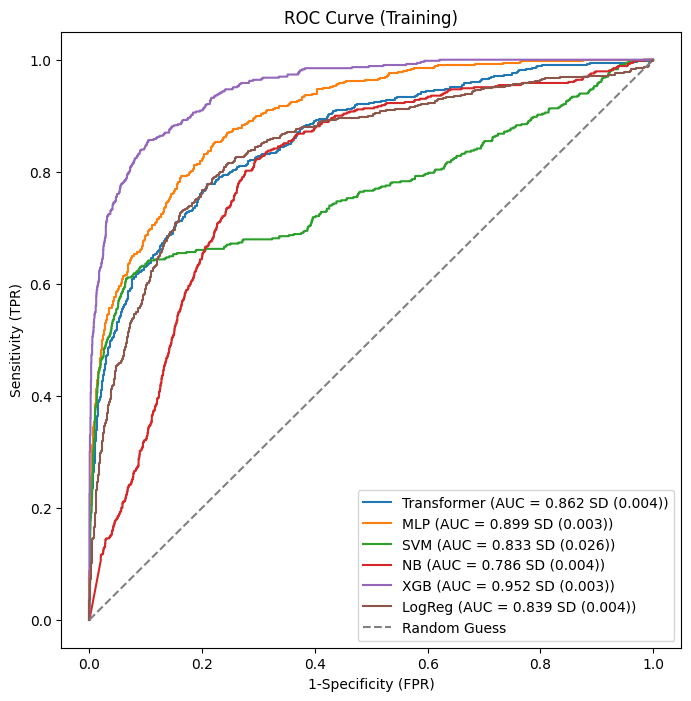

In [54]:
plt.figure(figsize=(8, 8))

for model_name in models_10cv:
    y_score = models_10cv[model_name][used_folds[model_name]].predict_proba(cv_train_list[used_folds[model_name]][list(features_ordering[curve_input_features[model_name]])])[:, 1]
    fpr, tpr, _ = roc_curve(cv_train_list[used_folds[model_name]][label], y_score)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {metric_averages[model_name]["train_auc"]:.3f} SD ({metric_averages[model_name]["train_auc_std"]:.3f}))')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('ROC Curve (Training)')
plt.legend()
plt.show()

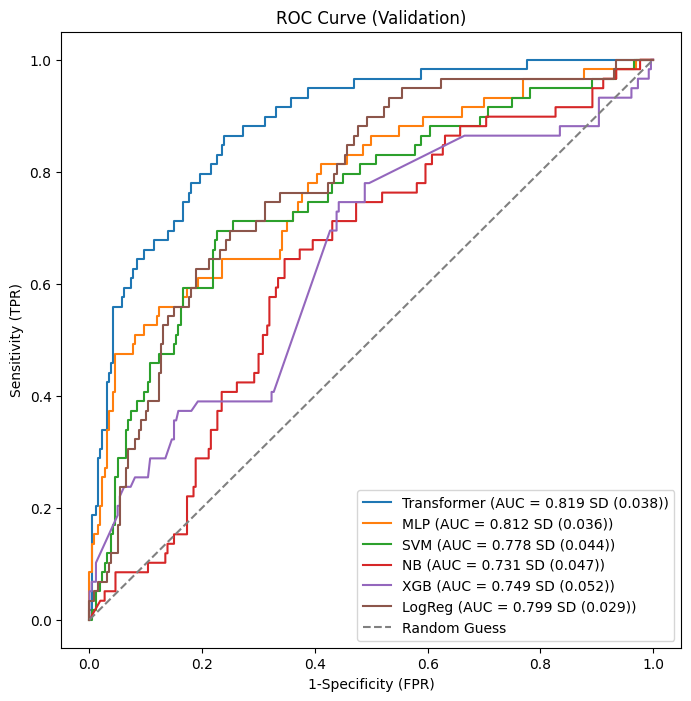

In [55]:
plt.figure(figsize=(8, 8))

for model_name in models_10cv:
    y_score = models_10cv[model_name][used_folds[model_name]].predict_proba(cv_val_list[used_folds[model_name]][list(features_ordering[curve_input_features[model_name]])])[:, 1]
    fpr, tpr, _ = roc_curve(cv_val_list[used_folds[model_name]][label], y_score)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {metric_averages[model_name]["val_auc"]:.3f} SD ({metric_averages[model_name]["val_auc_std"]:.3f}))')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('ROC Curve (Validation)')
plt.legend()
plt.show()

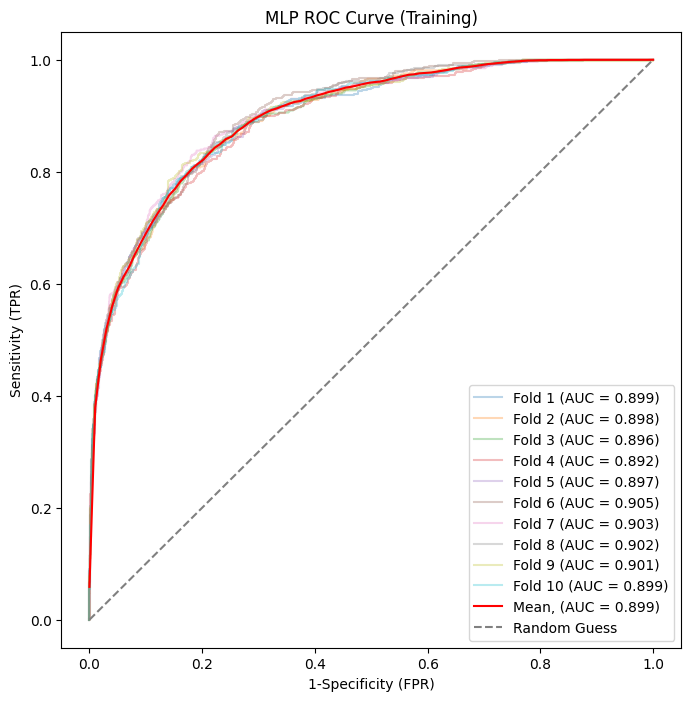

In [56]:
plt.figure(figsize=(8, 8))

model = 'MLP'

mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

for i, model in enumerate(models_10cv['MLP']):
    y_score = model.predict_proba(cv_train_list[i][list(features_ordering[curve_input_features['MLP']])])[:, 1]
    fpr, tpr, _ = roc_curve(cv_train_list[i][label], y_score)
    auc_value = auc(fpr, tpr)  # Calculate AUC for each fold
    plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {auc_value:.3f})', alpha = 0.3)

    mean_tpr += np.interp(mean_fpr, fpr, tpr)

mean_tpr /= 10
plt.plot(mean_fpr, mean_tpr, color='red', label = f'Mean, (AUC = {metric_averages["MLP"]["train_auc"]:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('MLP ROC Curve (Training)')
plt.legend()
plt.show()

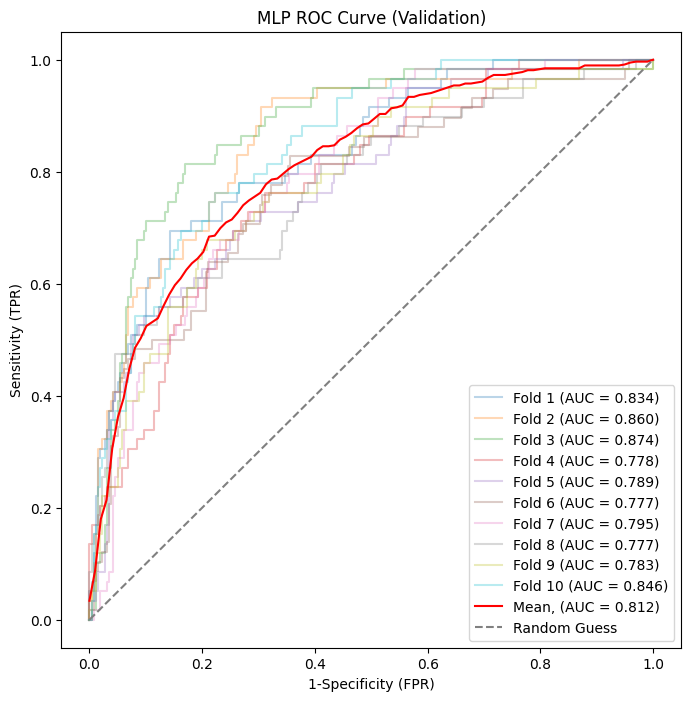

In [57]:
plt.figure(figsize=(8, 8))

mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

for i, model in enumerate(models_10cv['MLP']):
    y_score = model.predict_proba(cv_val_list[i][list(features_ordering[curve_input_features['MLP']])])[:, 1]
    fpr, tpr, _ = roc_curve(cv_val_list[i][label], y_score)
    auc_value = auc(fpr, tpr)  # Calculate AUC for each fold
    plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {auc_value:.3f})', alpha = 0.3)

    mean_tpr += np.interp(mean_fpr, fpr, tpr)

mean_tpr /= 10
plt.plot(mean_fpr, mean_tpr, color='red', label = f'Mean, (AUC = {metric_averages["MLP"]["val_auc"]:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('MLP ROC Curve (Validation)')
plt.legend()
plt.show()

### 2.4.2 PR Curve
- Comparable models: 1 of 10 fold Train and Val
- EXTRFR's 10 fold and Train and Val

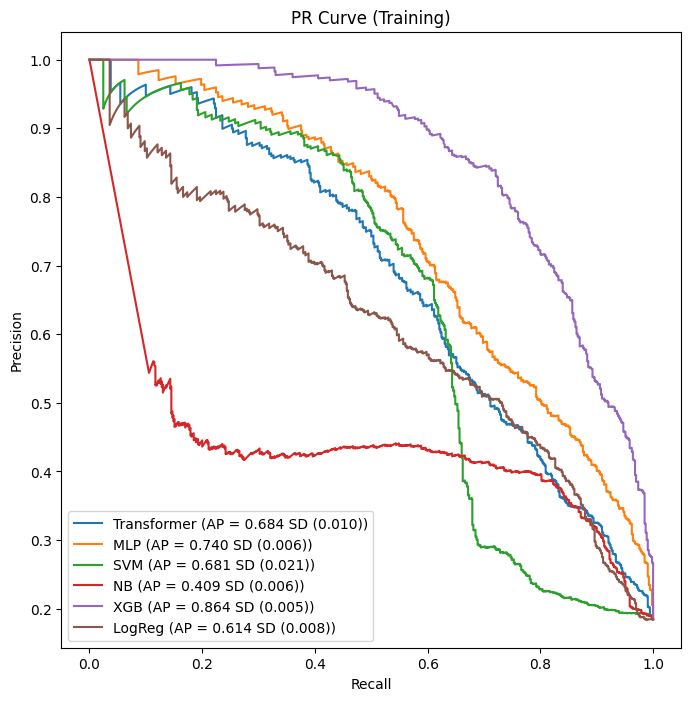

In [58]:
plt.figure(figsize=(8, 8))

# Plot PR curves for each model
for model_name in models_10cv:
    y_score = models_10cv[model_name][used_folds[model_name]].predict_proba(cv_train_list[used_folds[model_name]][list(features_ordering[curve_input_features[model_name]])])[:, 1]

    # Plot PR curve
    precision, recall, _ = precision_recall_curve(cv_train_list[used_folds[model_name]][label], y_score)
    plt.plot(recall, precision, label=f'{model_name} (AP = {metric_averages[model_name]["train_aps"]:.3f} SD ({metric_averages[model_name]["train_aps_std"]:.3f}))')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve (Training)')
plt.legend()
plt.show()

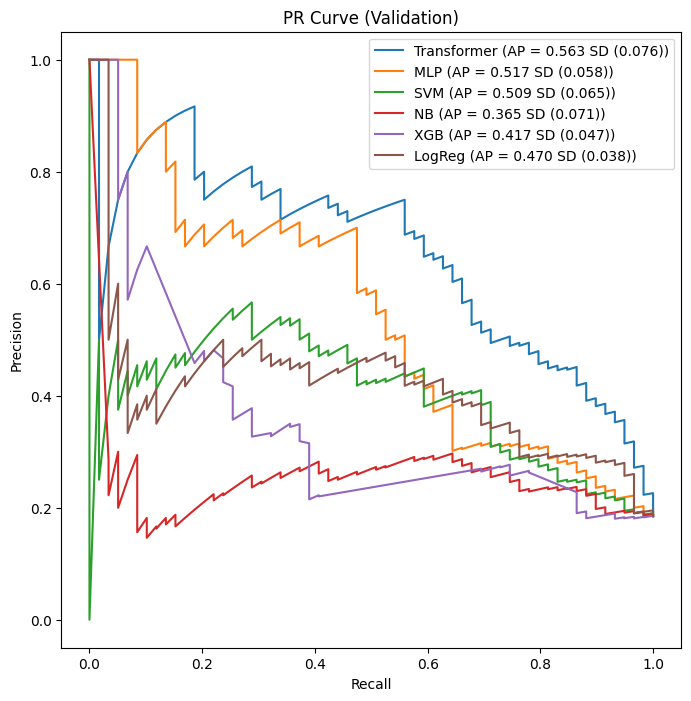

In [59]:
plt.figure(figsize=(8, 8))

# Plot PR curves for each model
for model_name in models_10cv:
    y_score = models_10cv[model_name][used_folds[model_name]].predict_proba(cv_val_list[used_folds[model_name]][list(features_ordering[curve_input_features[model_name]])])[:, 1]

    # Plot PR curve
    precision, recall, _ = precision_recall_curve(cv_val_list[used_folds[model_name]][label], y_score)
    plt.plot(recall, precision, label=f'{model_name} (AP = {metric_averages[model_name]["val_aps"]:.3f} SD ({metric_averages[model_name]["val_aps_std"]:.3f}))')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve (Validation)')
plt.legend()
plt.show()

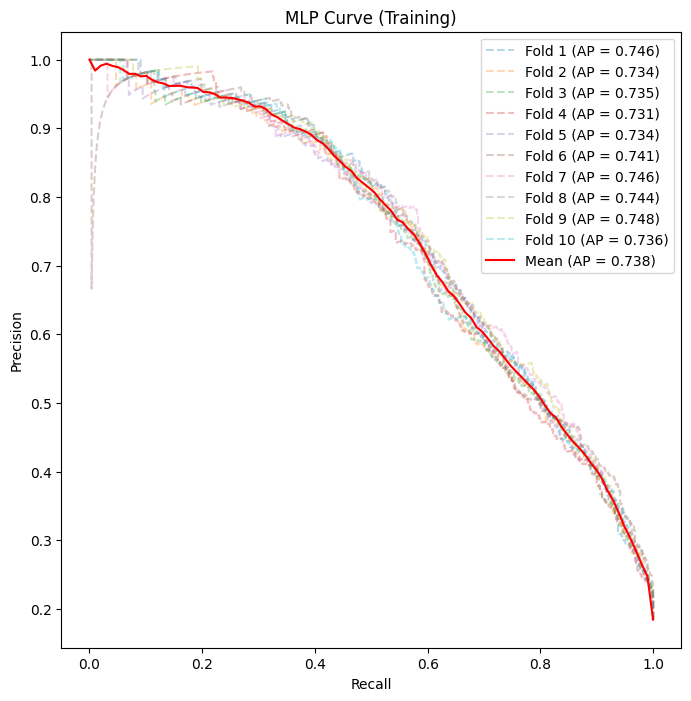

In [60]:
plt.figure(figsize=(8, 8))

mean_recall = np.linspace(0, 1, 100)
mean_precision = np.zeros_like(mean_recall)

# Plot PR curves for each model
for i, model in enumerate(models_10cv['MLP']):
    y_score = model.predict_proba(cv_train_list[i][list(features_ordering[curve_input_features['MLP']])])[:, 1]

    # Plot PR curve
    precision, recall, _ = precision_recall_curve(cv_train_list[i][label], y_score)
    ap = average_precision_score(cv_train_list[i][label], y_score)
    plt.plot(recall, precision, label=f'Fold {i+1} (AP = {ap:.3f})', linestyle='--', alpha=0.3)

    mean_precision += np.interp(mean_recall, recall[::-1], precision[::-1])

mean_precision /= len(models_10cv['MLP'])

plt.plot(mean_recall, mean_precision, color='red', label=f'Mean (AP = {np.mean(mean_precision):.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('MLP Curve (Training)')
plt.legend()
plt.show()


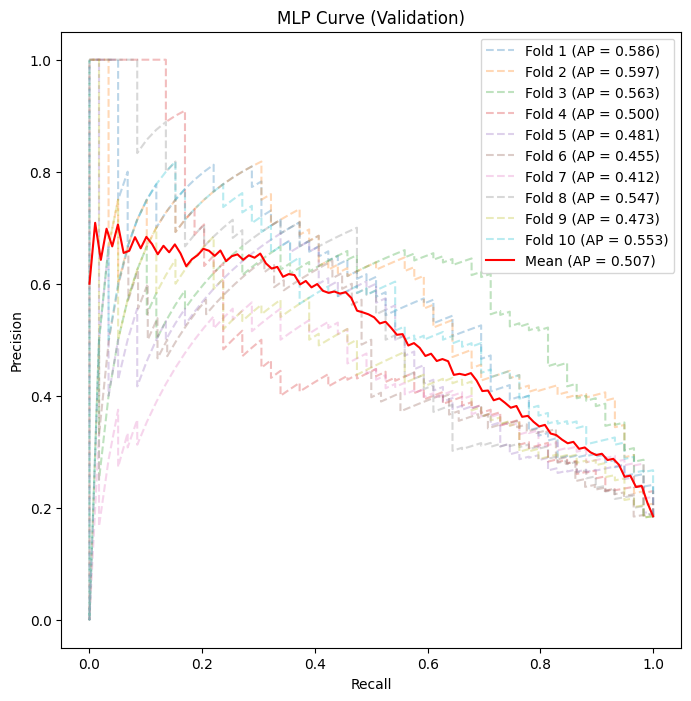

In [61]:
plt.figure(figsize=(8, 8))

mean_recall = np.linspace(0, 1, 100)
mean_precision = np.zeros_like(mean_recall)

# Plot PR curves for each model
for i, model in enumerate(models_10cv['MLP']):
    y_score = model.predict_proba(cv_val_list[i][list(features_ordering[curve_input_features['MLP']])])[:, 1]

    # Plot PR curve
    precision, recall, _ = precision_recall_curve(cv_val_list[i][label], y_score)
    ap = average_precision_score(cv_val_list[i][label], y_score)
    plt.plot(recall, precision, label=f'Fold {i+1} (AP = {ap:.3f})', linestyle='--', alpha=0.3)

    mean_precision += np.interp(mean_recall, recall[::-1], precision[::-1]) # reversed

mean_precision /= len(models_10cv['MLP'])

plt.plot(mean_recall, mean_precision, color='red', label=f'Mean (AP = {np.mean(mean_precision):.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('MLP Curve (Validation)')
plt.legend()
plt.show()


#### 2.4.3 Decision Curve (Analysis)
- Comparable models: 1 of 10 fold Train and Val

In [78]:
dca_used_folds = {'Transformer': 2, 'MLP': 6, 'NB': 8, 'SVM': 9, 'XGB': 8, 'LogReg': 8}

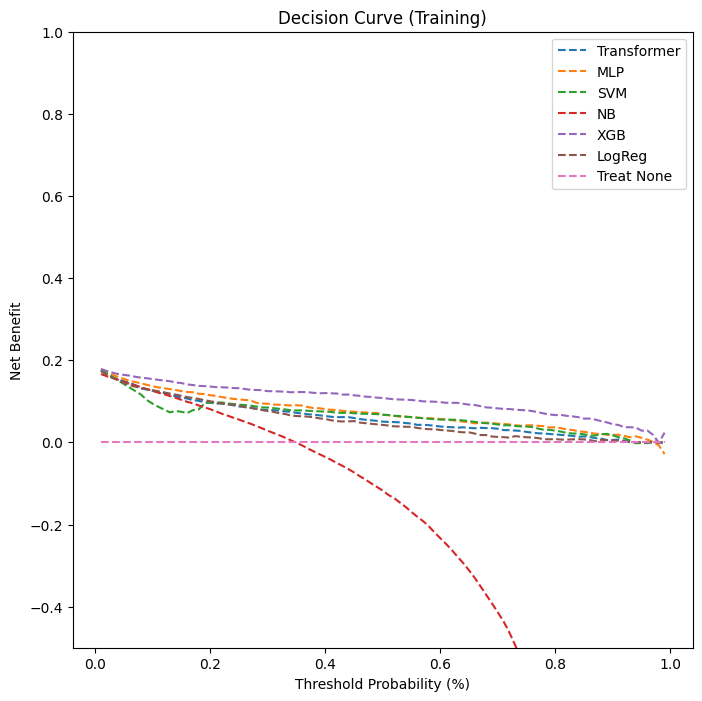

In [79]:
plt.figure(figsize=(8, 8))

# Define thresholds
thresholds = [x / 100 for x in range(1, 100)]
net_benefit_all = None  # Initialize net_benefit_all outside the loop

# Plot Decision Curves for each model
for model_name in models_10cv:
    y_score = models_10cv[model_name][dca_used_folds[model_name]].predict_proba(cv_train_list[dca_used_folds[model_name]][list(features_ordering[curve_input_features[model_name]])])[:, 1]
    y_true = cv_train_list[dca_used_folds[model_name]][label]

    net_benefit_treated = []
    n = len(y_score)

    for threshold in thresholds:
        tp = len(y_score[(y_score > threshold) & (y_true == 1)])
        fp = len(y_score[(y_score > threshold) & (y_true == 0)])

        net_benefit_treated.append(tp/n - fp*(threshold/(1-threshold))/n)

    plt.plot(thresholds, net_benefit_treated, label=f'{model_name}', linestyle='--')

    # Specific handling for 'ExtraRFC' model
    if model_name == 'ExtraRFC':
        net_benefit_all = []

        for threshold in thresholds:
            tp = len(y_score[(y_score > threshold) & (y_true == 1)])
            fn = len(y_score[(y_score <= threshold) & (y_true == 1)])
            pi = (tp + fn)/n

            net_benefit_all.append(pi - (1-pi)*(threshold/(1-threshold)))

# Plot "Treat All" curve for the ExtraRFC model if it was computed
if net_benefit_all is not None:
    plt.plot(thresholds, net_benefit_all, label='Treat All', linestyle='--')

# Plot "Treat None" curve
net_benefit_treated = [0] * len(thresholds)
plt.plot(thresholds, net_benefit_treated, label='Treat None', linestyle='--')

plt.xlabel('Threshold Probability (%)')
plt.ylabel('Net Benefit')
plt.ylim([-0.5, 1])
plt.title('Decision Curve (Training)')
plt.legend()
plt.show()


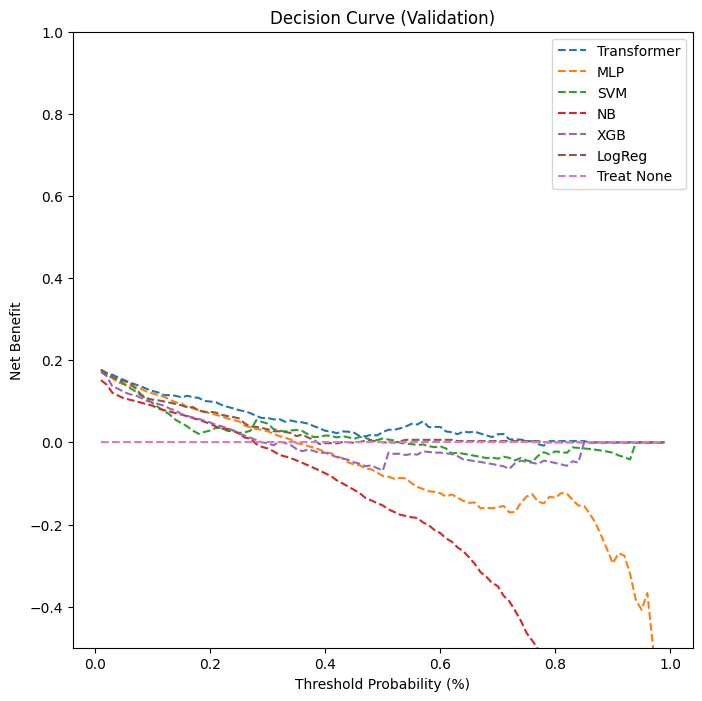

In [80]:
plt.figure(figsize=(8, 8))

# Define thresholds
thresholds = [x / 100 for x in range(1, 100)]
net_benefit_all = None  # Initialize net_benefit_all outside the loop

# Plot Decision Curves for each model
for model_name in models_10cv:
    y_score = models_10cv[model_name][dca_used_folds[model_name]].predict_proba(cv_val_list[dca_used_folds[model_name]][list(features_ordering[curve_input_features[model_name]])])[:, 1]
    y_true = cv_val_list[dca_used_folds[model_name]][label]

    net_benefit_treated = []
    n = len(y_score)

    for threshold in thresholds:
        tp = len(y_score[(y_score > threshold) & (y_true == 1)])
        fp = len(y_score[(y_score > threshold) & (y_true == 0)])

        net_benefit_treated.append(tp/n - fp*(threshold/(1-threshold))/n)

    plt.plot(thresholds, net_benefit_treated, label=f'{model_name}', linestyle='--')

    # Specific handling for 'ExtraRFC' model
    if model_name == 'ExtraRFC':
        net_benefit_all = []

        for threshold in thresholds:
            tp = len(y_score[(y_score > threshold) & (y_true == 1)])
            fn = len(y_score[(y_score <= threshold) & (y_true == 1)])
            pi = (tp + fn)/n

            net_benefit_all.append(pi - (1-pi)*(threshold/(1-threshold)))

# Plot "Treat All" curve for the ExtraRFC model if it was computed
if net_benefit_all is not None:
    plt.plot(thresholds, net_benefit_all, label='Treat All', linestyle='--')

# Plot "Treat None" curve
net_benefit_treated = [0] * len(thresholds)
plt.plot(thresholds, net_benefit_treated, label='Treat None', linestyle='--')

plt.xlabel('Threshold Probability (%)')
plt.ylabel('Net Benefit')
plt.ylim([-0.5, 1])
plt.title('Decision Curve (Validation)')
plt.legend()
plt.show()


### 2.4.4 Calibration Curve
- Comparable models: 1 of 10 fold Train and Val

In [133]:
cc_used_folds = {'Transformer': 2, 'MLP': 6, 'NB': 8, 'SVM': 9, 'XGB': 1, 'LogReg': 5}

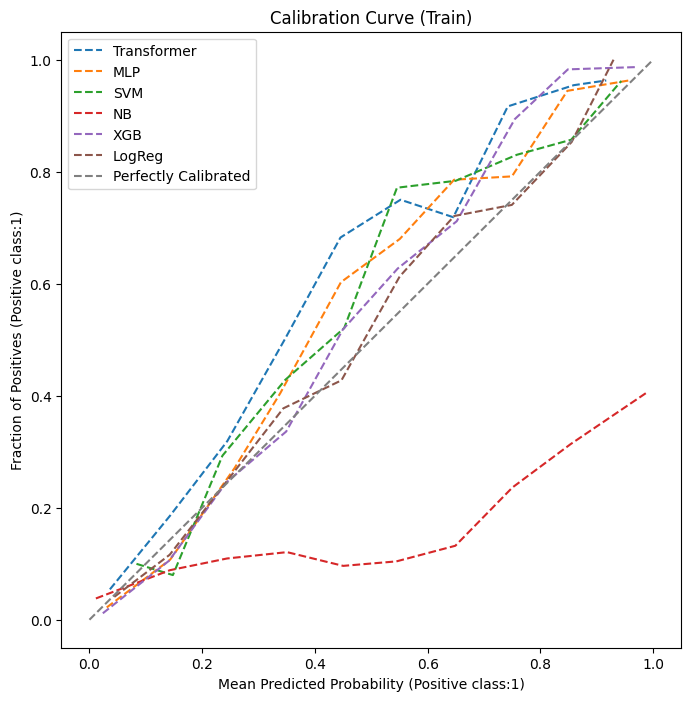

In [134]:
plt.figure(figsize=(8, 8))

# Plot Calibration Curves for each model
for model_name in models_10cv:
    y_score = models_10cv[model_name][cc_used_folds[model_name]].predict_proba(cv_train_list[cc_used_folds[model_name]][list(features_ordering[curve_input_features[model_name]])])[:, 1]
    y_true = cv_train_list[cc_used_folds[model_name]][label]

    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, label=f'{model_name}', linestyle='--')

# Plot the "Perfectly Calibrated" line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability (Positive class:1)')
plt.ylabel('Fraction of Positives (Positive class:1)')
plt.title('Calibration Curve (Train)')
plt.legend()
plt.show()


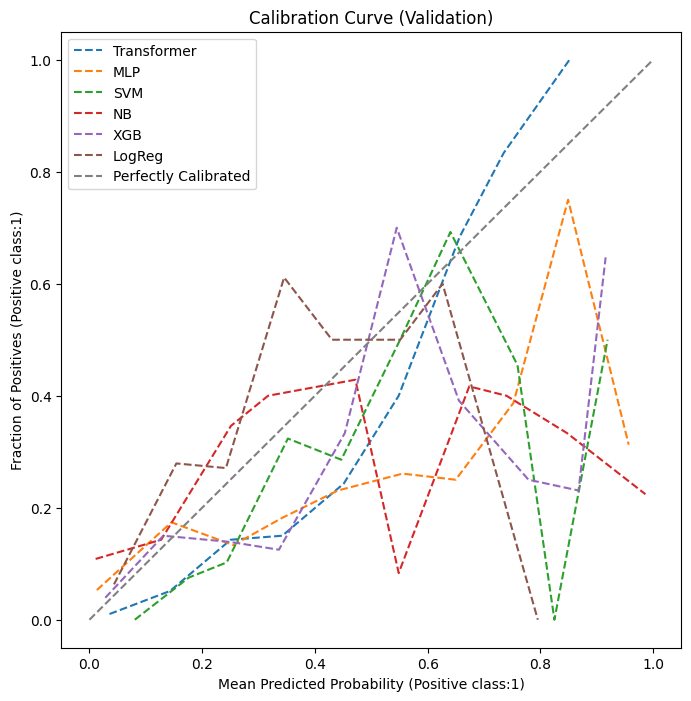

In [135]:
plt.figure(figsize=(8, 8))

# Plot Calibration Curves for each model
for model_name in models_10cv:
    y_score = models_10cv[model_name][cc_used_folds[model_name]].predict_proba(cv_val_list[cc_used_folds[model_name]][list(features_ordering[curve_input_features[model_name]])])[:, 1]
    y_true = cv_val_list[cc_used_folds[model_name]][label]

    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, label=f'{model_name}', linestyle='--')

# Plot the "Perfectly Calibrated" line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability (Positive class:1)')
plt.ylabel('Fraction of Positives (Positive class:1)')
plt.title('Calibration Curve (Validation)')
plt.legend()
plt.show()


### 2.4.5 Delong Test

- Comparable models: 1 of 10 fold Train and Val

In [136]:
# Source: https://www.kaggle.com/code/dakshbardoliwala/delongs-and-t-test

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float64)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float64)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float64)
    ty = np.empty([k, n], dtype=np.float64)
    tz = np.empty([k, m + n], dtype=np.float64)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

In [137]:
def getDeLong(y_best, y_pred, y_true):
    res = delong_roc_test(y_true, y_best, y_pred)[0][0]
    print("DeLongs Result : ")
    # print("\tlog_10(P Value) : ", res)
    p = 10 ** res
    print("\tP Value : ", p)

In [153]:
import json

# Pick model for plotting
delong_fold = 9

mlp_delong = models_10cv['MLP'][delong_fold]
transformer_delong = models_10cv['Transformer'][delong_fold]
svm_delong = models_10cv['SVM'][delong_fold]
nb_delong = models_10cv['NB'][delong_fold]
xgb_delong = models_10cv['XGB'][delong_fold]
logreg_delong = models_10cv['LogReg'][delong_fold]

delong_model_list = [transformer_delong, mlp_delong, svm_delong, nb_delong, xgb_delong, logreg_delong]
delong_model_names = ['Transformer', 'MLP', 'SVM', 'NB', 'XGB', 'LogReg']

# Dictionary to store results
delong_results = {}

for i in range(len(delong_model_list)):
    for j in range(len(delong_model_list)):
        model_pair = f'{delong_model_names[i]} vs {delong_model_names[j]}'
        print(model_pair)

        # Perform the DeLong test
        p_value = getDeLong(
            delong_model_list[i].predict_proba(cv_val_list[delong_fold][list(features_ordering[curve_input_features[delong_model_names[i]]])])[:, 1],
            delong_model_list[j].predict_proba(cv_val_list[delong_fold][list(features_ordering[curve_input_features[delong_model_names[j]]])])[:, 1],
            cv_val_list[delong_fold][label]
        )

        # Store the result in the dictionary
        delong_results[model_pair] = p_value

# Save the results as a JSON file
with open(home_directory+'Presentables/delong_results.json', 'w') as json_file:
    json.dump(delong_results, json_file, indent=4)


Transformer vs Transformer
DeLongs Result : 
	P Value :  nan
Transformer vs MLP
DeLongs Result : 
	P Value :  0.8356951910871836
Transformer vs SVM
DeLongs Result : 
	P Value :  0.00015045762782954107
Transformer vs NB
DeLongs Result : 
	P Value :  1.969449341174266e-05
Transformer vs XGB
DeLongs Result : 
	P Value :  0.006013870036466257
Transformer vs LogReg
DeLongs Result : 
	P Value :  0.0008931134773363047
MLP vs Transformer
DeLongs Result : 
	P Value :  0.8356951910871836
MLP vs MLP
DeLongs Result : 
	P Value :  nan
MLP vs SVM
DeLongs Result : 
	P Value :  0.0009405316370002366
MLP vs NB
DeLongs Result : 
	P Value :  7.314633704301447e-06
MLP vs XGB
DeLongs Result : 
	P Value :  0.011049565975123446
MLP vs LogReg
DeLongs Result : 
	P Value :  0.00035910125859037884
SVM vs Transformer
DeLongs Result : 
	P Value :  0.00015045762782954107
SVM vs MLP
DeLongs Result : 
	P Value :  0.0009405316370002366
SVM vs SVM
DeLongs Result : 
	P Value :  nan
SVM vs NB
DeLongs Result : 
	P Value :

## 3. Test Dataset Evaluation
    - 70% Train Dataset; 30% Test Dataset

In [154]:
Final_Model = Transformer(**{'hidden_dim': 32, 'num_transformer_layers': 3, 'num_mlp_layers': 1, 'dropout': 0, 'batch_size': 128, 'nhead': 8, 'epochs': 10, 'lr': 0.001, 'batchnorm': False, 'grad_clip': True,
                                                   'random_state': SEED,
                                                   'loss': nn.CrossEntropyLoss(),
                                                   'rootpath': './',
                                                   'TabularDataFactory': TabularDataFactory,
                                                   'TabularDataset': TabularDataset,
                                                   'name': 'Transformer',
                                                   'input_dim': 9,
                                                   'output_dim': 2,
                                                   'mode': 'Classification',
                                                   'verbose': False})

Final_Model.fit(train_data[list(features_ordering[curve_input_features['Transformer']])], train_data[label])

In [156]:
final_train_pred = Final_Model.predict(train_data[list(features_ordering[curve_input_features['Transformer']])])
final_test_pred = Final_Model.predict(test_data[list(features_ordering[curve_input_features['Transformer']])])

final_train_pred_prob = Final_Model.predict_proba(train_data[list(features_ordering[curve_input_features['Transformer']])])
final_test_pred_prob = Final_Model.predict_proba(test_data[list(features_ordering[curve_input_features['Transformer']])])

### 3.1 Metrics
- 70% train and 30% test:
    - AUC(SD)
    - Precision (PPV)
    - Sensitivity
    - Specificity
    - NPV

- other round test datasets:
    - sensitivity
    - specificity

In [157]:
def get_test_evaluation_statistics(model, feature_ordering, feature_input, data):
        pred_y = model.predict(data[list(features_ordering[feature_input])])

        pred_prob_y = model.predict_proba(data[list(features_ordering[feature_input])])

        accuracy = accuracy_score(data[label], pred_y)

        precision = precision_score(data[label], pred_y)

        sensitivity = recall_score(data[label], pred_y)

        conf_matrix = confusion_matrix(data[label], pred_y)
        tn, fp, fn, tp = conf_matrix.ravel()

        specificity = tn / (tn + fp)

        npv = tn / (tn + fn)

        aucs = roc_auc_score(data[label], pred_prob_y[:, 1])

        aps = average_precision_score(data[label], pred_prob_y[:,1])

        f1 = f1_score(data[label], pred_y)

        return pred_y, pred_prob_y, accuracy, precision, sensitivity, specificity, npv, aucs, aps, f1

In [158]:
test_set_metrics = {}
dataset_names = ['train_data', 'test_data']

for i, dataset in enumerate([train_data, test_data]):
    pred_y, pred_prob_y, accuracy, precision, sensitivity, specificity, npv, aps, aucs, f1 = get_test_evaluation_statistics(Final_Model, features_ordering, curve_input_features['Transformer'], dataset)
    test_set_metrics[dataset_names[i]] = {'accuracy': accuracy, 'precision': precision, 'sensitivity': sensitivity, 'specificity': specificity, 'npv': npv, 'aucs': aucs, 'aps': aps, 'f1_score': f1}

test_set_metrics

{'train_data': {'accuracy': 0.8705329153605016,
  'precision': 0.7037037037037037,
  'sensitivity': 0.5161290322580645,
  'specificity': 0.9507881584006151,
  'npv': 0.8966642494561277,
  'aucs': 0.6860789437501713,
  'aps': 0.862145224280331,
  'f1_score': 0.5954946131243879},
 'test_data': {'accuracy': 0.8757309941520468,
  'precision': 0.7243243243243244,
  'sensitivity': 0.5296442687747036,
  'specificity': 0.9542600896860987,
  'npv': 0.8994082840236687,
  'aucs': 0.7072235804365714,
  'aps': 0.871178149205055,
  'f1_score': 0.6118721461187214}}

In [159]:
with open(home_directory+'Presentables/test_metrics.json', 'w') as f:
    json.dump({"test metrics": test_set_metrics}, f, indent=2)

### 3.2 Plots
#### 3.2.1 ROC Curve
- 70% test and test set required; 10 fold CV Train and Val can be found above
- other round test datasets required too


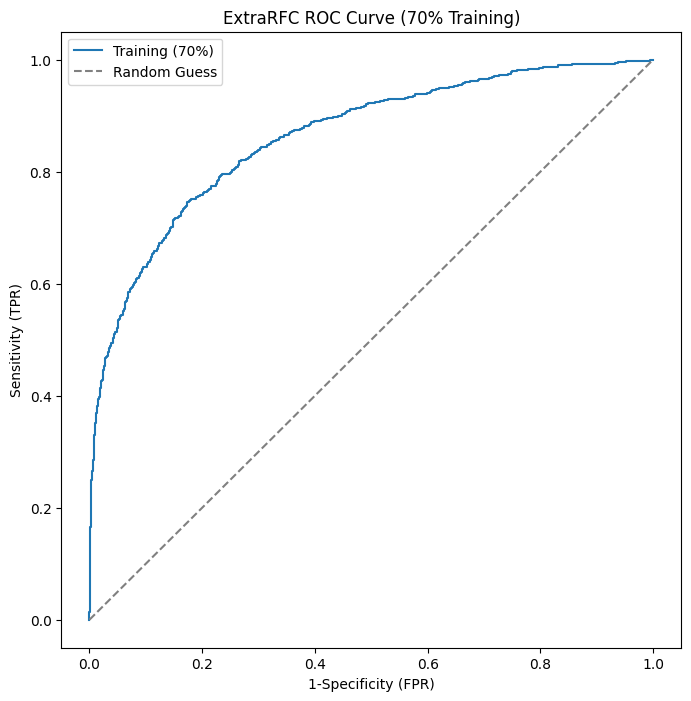

In [161]:
plt.figure(figsize=(8, 8))


y_score = Final_Model.predict_proba(train_data[list(features_ordering[curve_input_features['Transformer']])])[:, 1]
fpr, tpr, _ = roc_curve(train_data[label], y_score)
plt.plot(fpr, tpr, label=f'Training (70%)')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('ExtraRFC ROC Curve (70% Training)')
plt.legend()
plt.show()

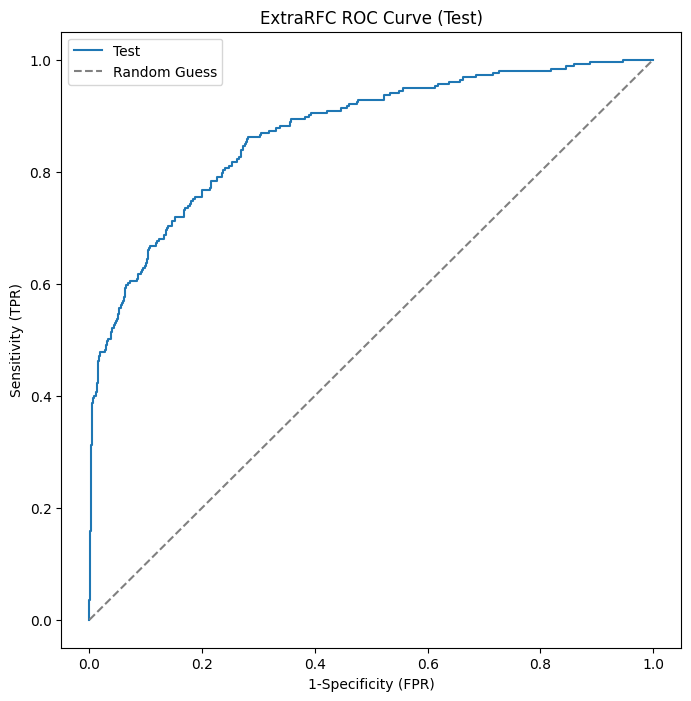

In [162]:
plt.figure(figsize=(8, 8))

y_score = Final_Model.predict_proba(test_data[list(features_ordering[curve_input_features['Transformer']])])[:, 1]
fpr, tpr, _ = roc_curve(test_data[label], y_score)
plt.plot(fpr, tpr, label=f'Test')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('ExtraRFC ROC Curve (Test)')
plt.legend()
plt.show()

#### 3.3.3 Decision Curve (Analysis)
- 70% train and test set required; 10 fold CV Train and Val can be found above

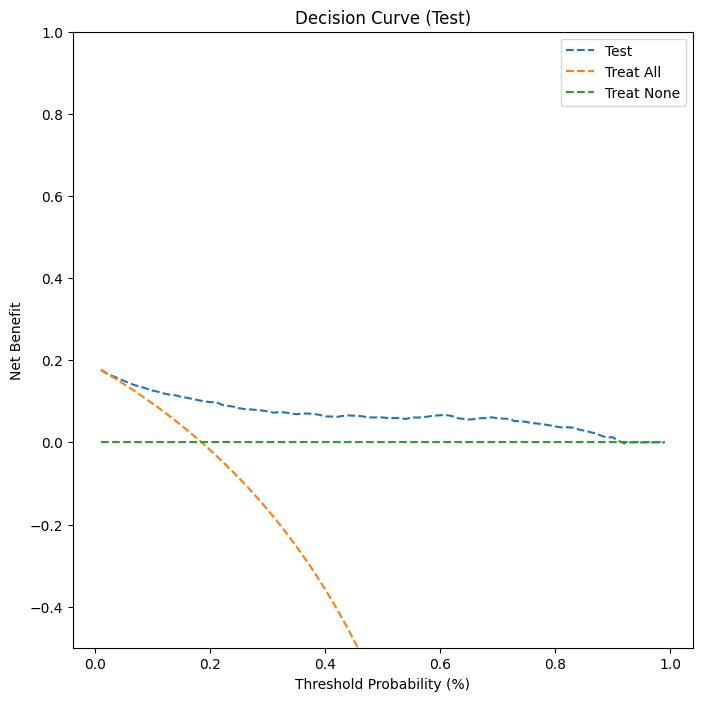

In [163]:
plt.figure(figsize=(8, 8))



thresholds = [x/100 for x in range(1, 100)]
y_score = Final_Model.predict_proba(test_data[list(features_ordering[curve_input_features['Transformer']])])[:, 1]
y_true = test_data[label]

net_benefit_treated = []
n = len(y_score)
for threshold in thresholds:
    tp = len(y_score[(y_score > threshold) & (y_true == 1)])
    fp = len(y_score[(y_score > threshold) & (y_true == 0)])
    fn = len(y_score[(y_score <= threshold) & (y_true == 1)])

    net_benefit_treated.append(tp/n - fp*(threshold/(1-threshold))/n)

plt.plot(thresholds, net_benefit_treated, label=f'Test', linestyle='--')

net_benefit_all = []

for threshold in thresholds:
    tp = len(y_score[(y_score > threshold) & (y_true == 1)])
    fn = len(y_score[(y_score <= threshold) & (y_true == 1)])
    pi = (tp + fn)/n

    net_benefit_all.append(pi - (1-pi)*(threshold/(1-threshold)))

net_benefit_treated = []
for threshold in thresholds:
    tp = 0
    fp = 0
    net_benefit_treated.append(tp/n - fp*(threshold/(1-threshold))/n)

plt.plot(thresholds, net_benefit_all, label='Treat All', linestyle='--')
plt.plot(thresholds, net_benefit_treated, label=f'Treat None', linestyle='--')

plt.xlabel('Threshold Probability (%)')
plt.ylabel('Net Benefit')
plt.ylim([-0.5, 1])
plt.title('Decision Curve (Test)')
plt.legend()
plt.show()

#### 3.3.4 Calibration Curve
- 70% train and test set required; 10 fold CV Train and Val can be found above

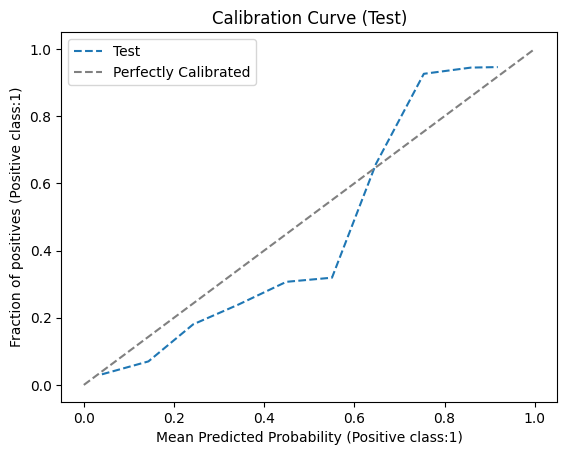

In [164]:
y_score = Final_Model.predict_proba(test_data[list(features_ordering[curve_input_features['Transformer']])])[:, 1]
y_true = test_data[label]
prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10, strategy='uniform')
plt.plot(prob_pred, prob_true, label=f'Test', linestyle='--')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability (Positive class:1)')
plt.ylabel('Fraction of positives (Positive class:1)')
plt.title('Calibration Curve (Test)')
plt.legend()
plt.show()

### 3.4 Confusion Matrix

- 70% train and test set required only

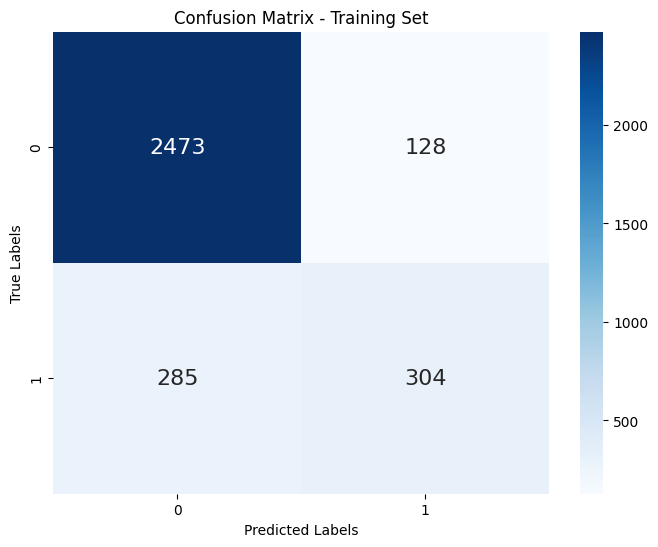

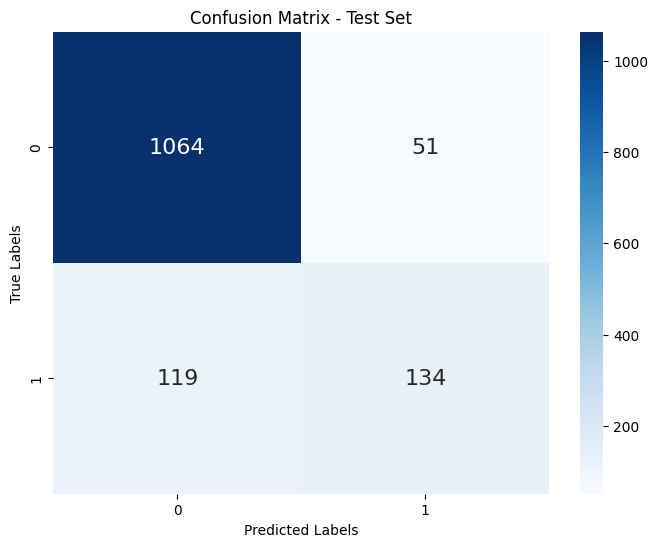

In [165]:
# Confusion Matrix

# Assuming y_train_true and final_train_pred are your true labels and predicted labels for the training set
conf_matrix_train = confusion_matrix(train_data[label], final_train_pred)

# Plot Confusion Matrix for Training Set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Assuming y_test_true and final_test_pred are your true labels and predicted labels for the test set
conf_matrix_test = confusion_matrix(test_data[label], final_test_pred)

# Plot Confusion Matrix for Test Set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## 4 Shap

- 30% Test

In [166]:
# Define a custom prediction function for SHAP to use
def model_predict(data):
    return Final_Model.predict_proba(data)

# First type of explainer (use this if Final_Model is not a tree-based model)
explainer = shap.Explainer(model_predict, test_data[list(features_ordering[curve_input_features['Transformer']])])
shap_values = explainer(test_data[list(features_ordering[curve_input_features['Transformer']])])

ExactExplainer explainer: 1369it [06:40,  3.41it/s]


#### 4.1 Whole Dataset

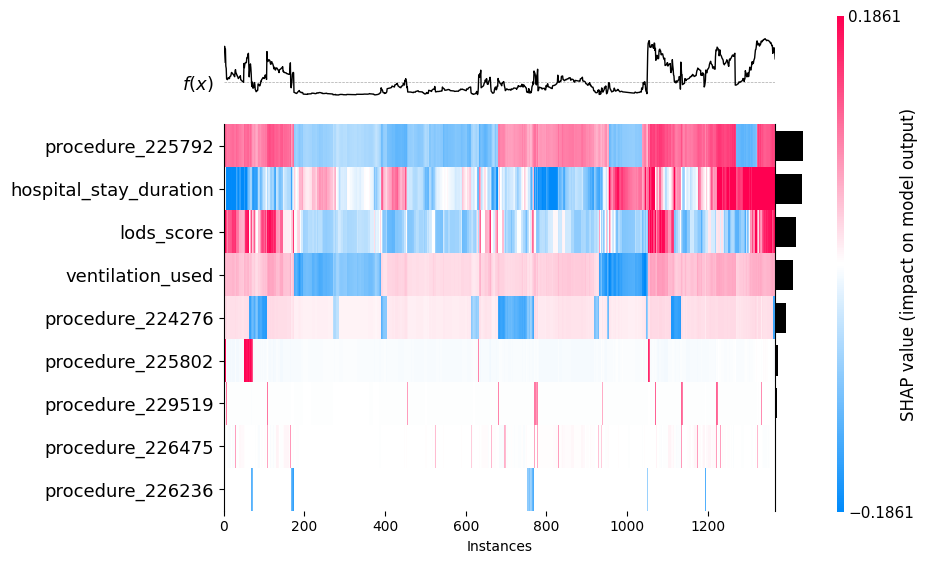

<Axes: xlabel='Instances'>

In [168]:
# heatmap
shap.plots.heatmap(shap_values[:,:, 1])

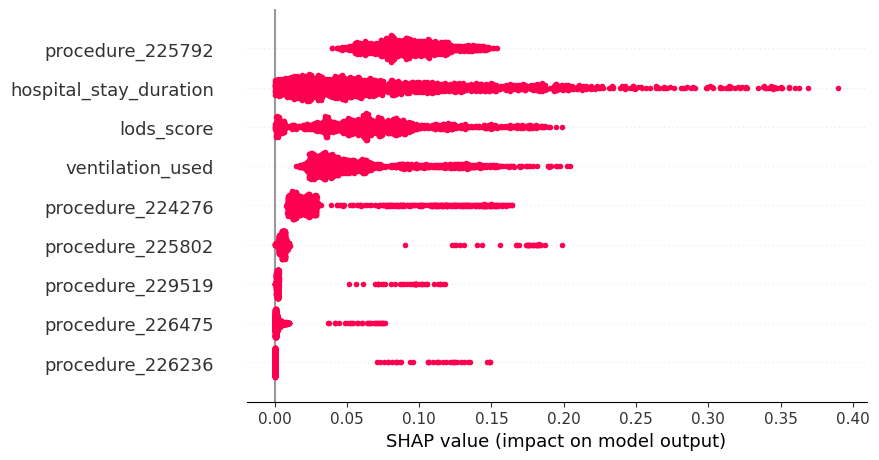

In [169]:
# absolute value shap value distribution plot over each feature (whole test set)
shap.plots.beeswarm(shap_values[:, :, 1].abs, color = "shap_red")

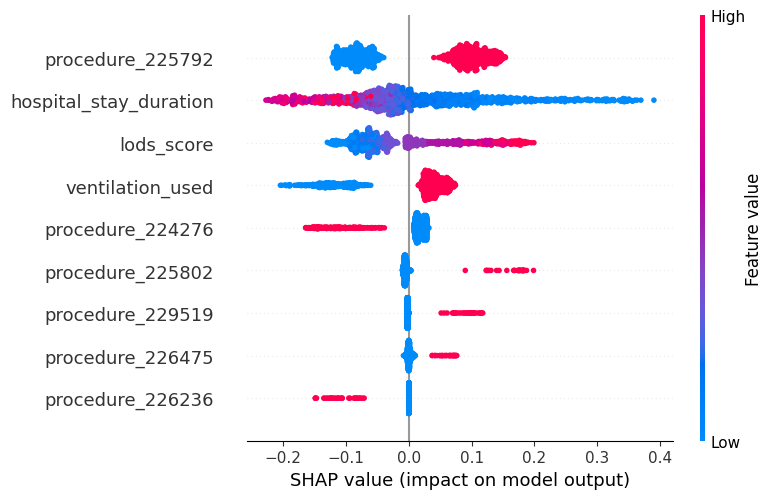

In [170]:
# shap value distribution plot over each feature (whole test set)
shap.summary_plot(shap_values[:, :, 1], test_data[list(features_ordering[curve_input_features['Transformer']])],
                  feature_names=list(features_ordering[curve_input_features['Transformer']]))

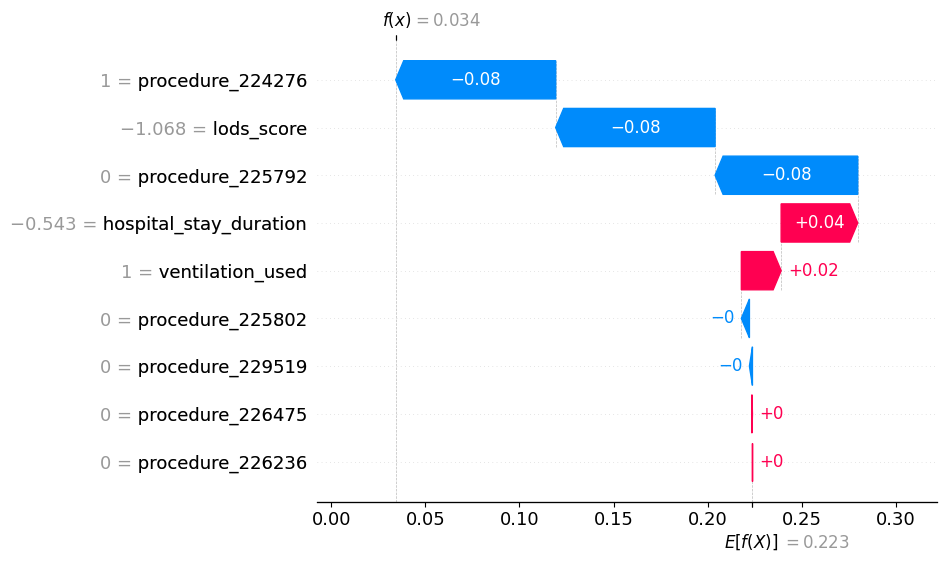

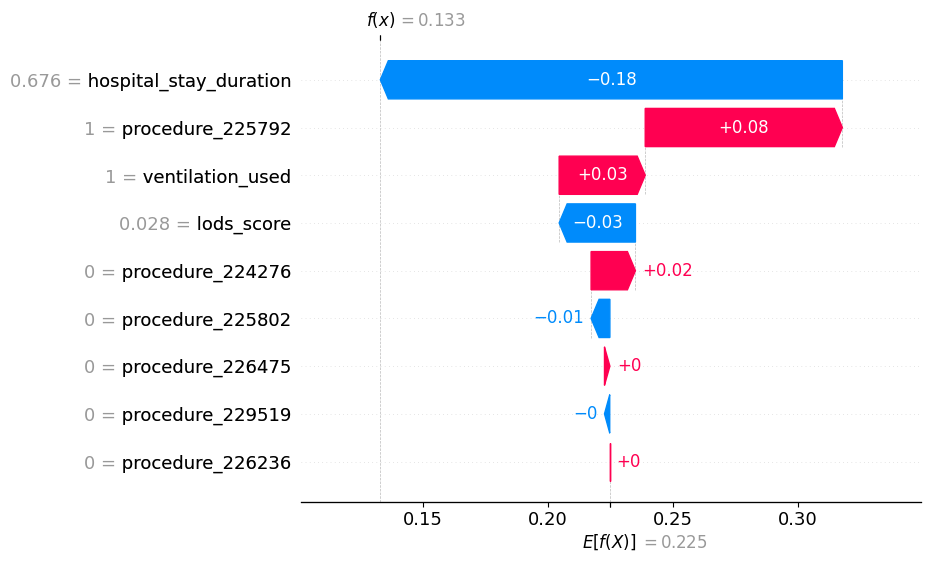

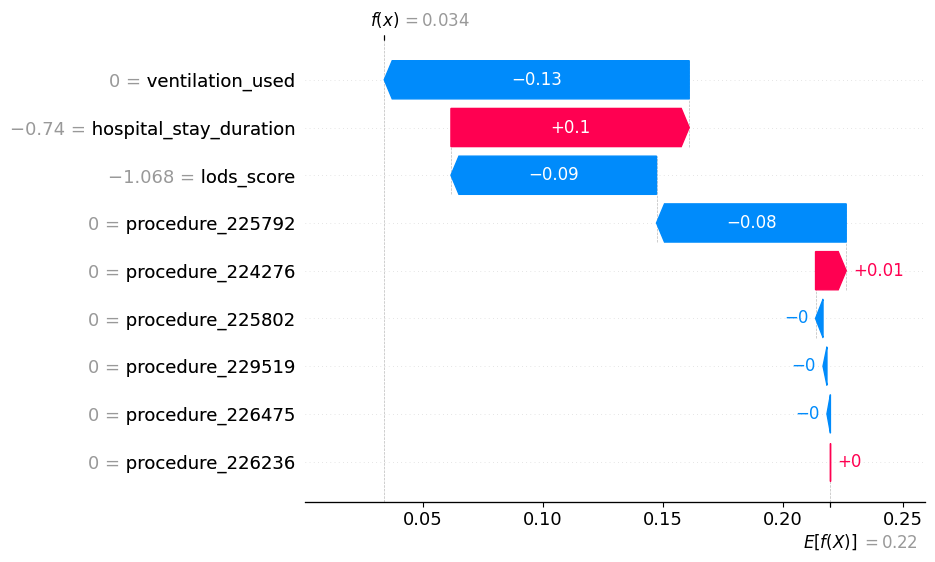

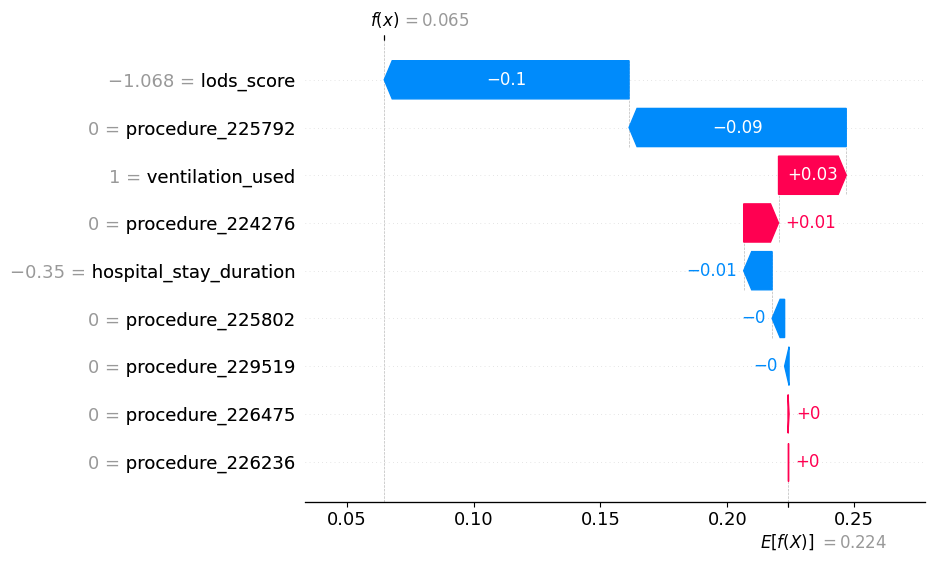

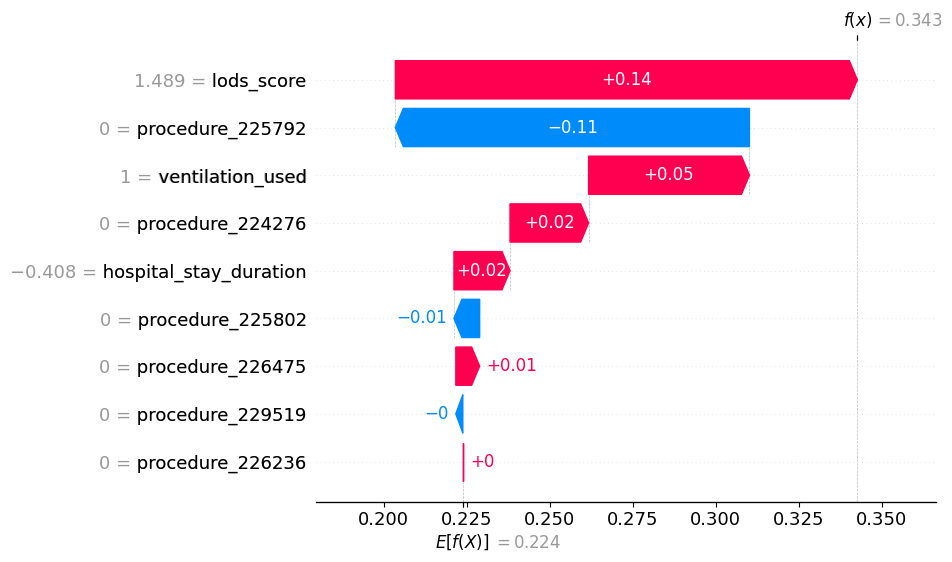

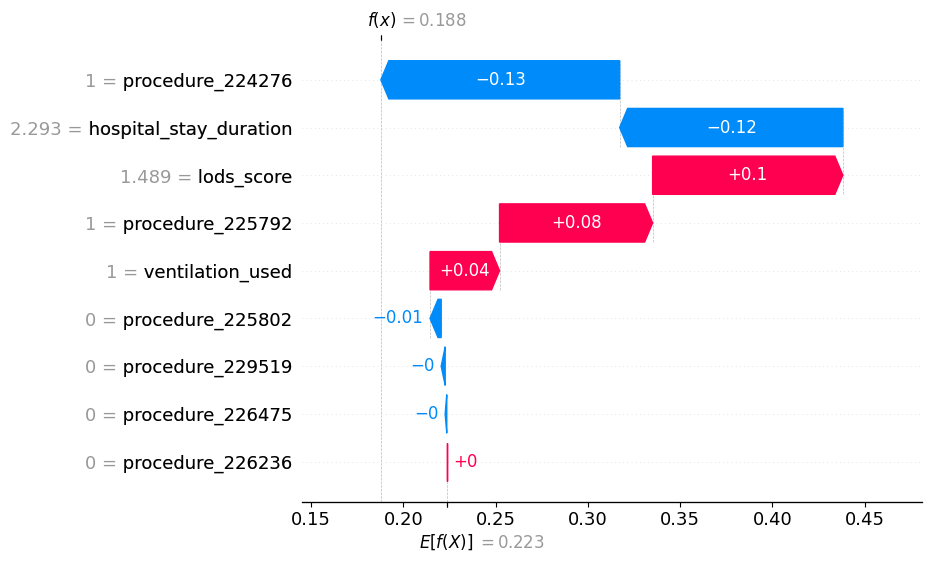

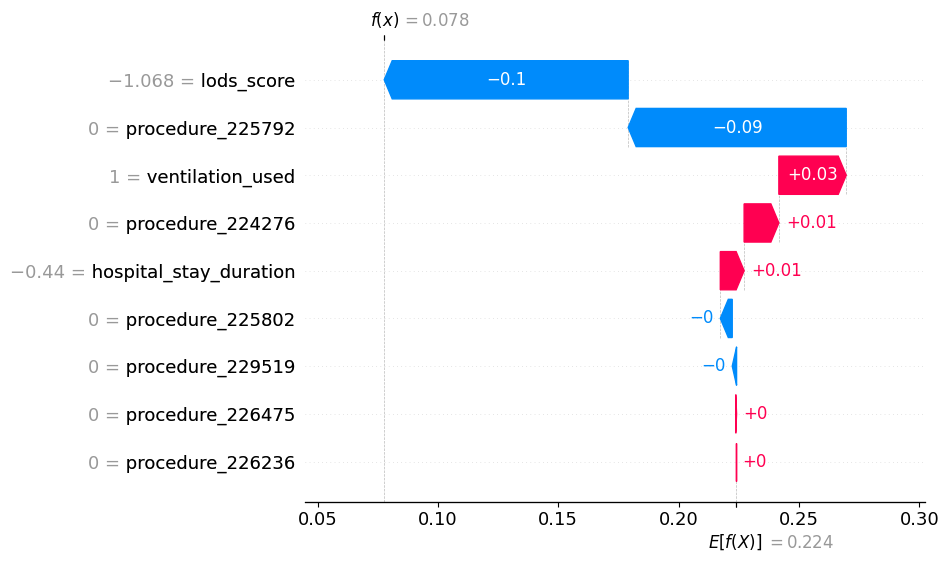

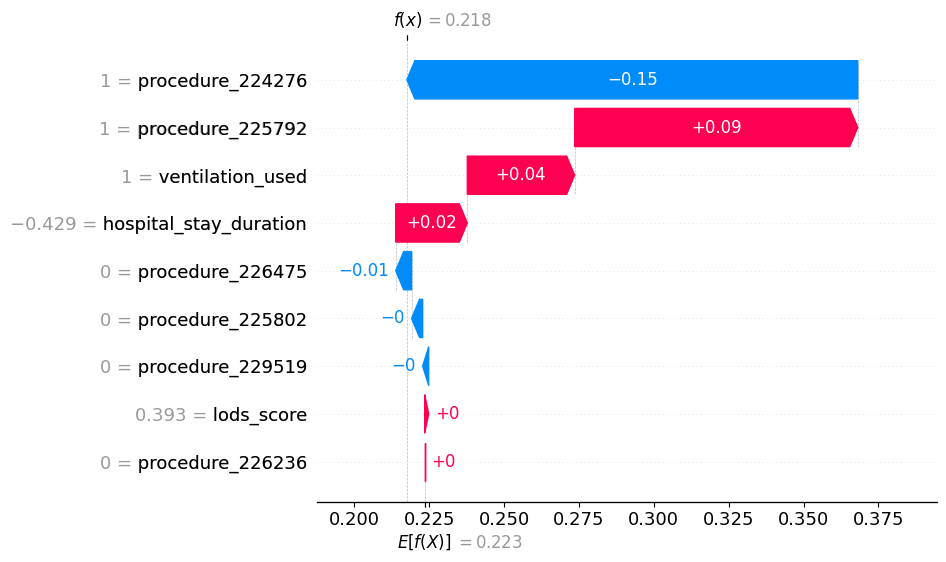

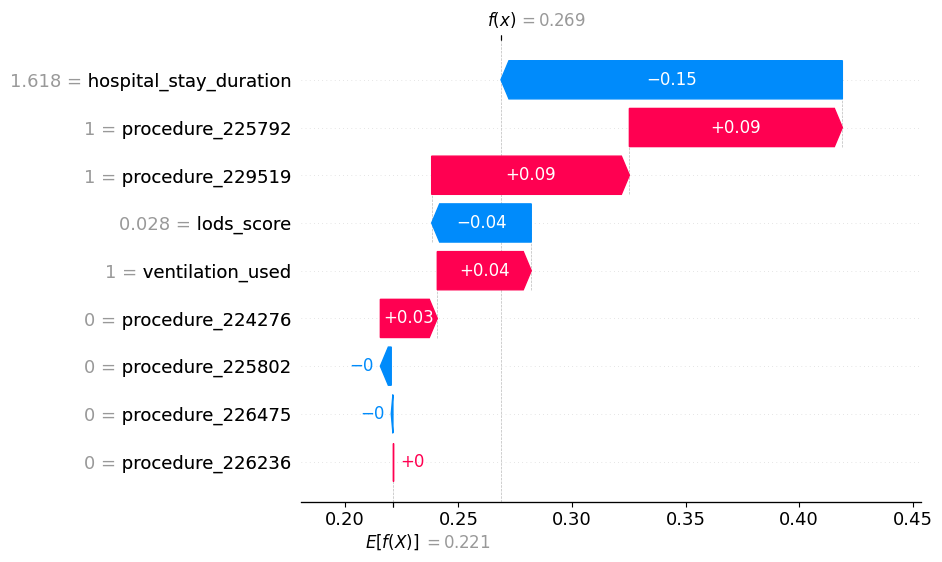

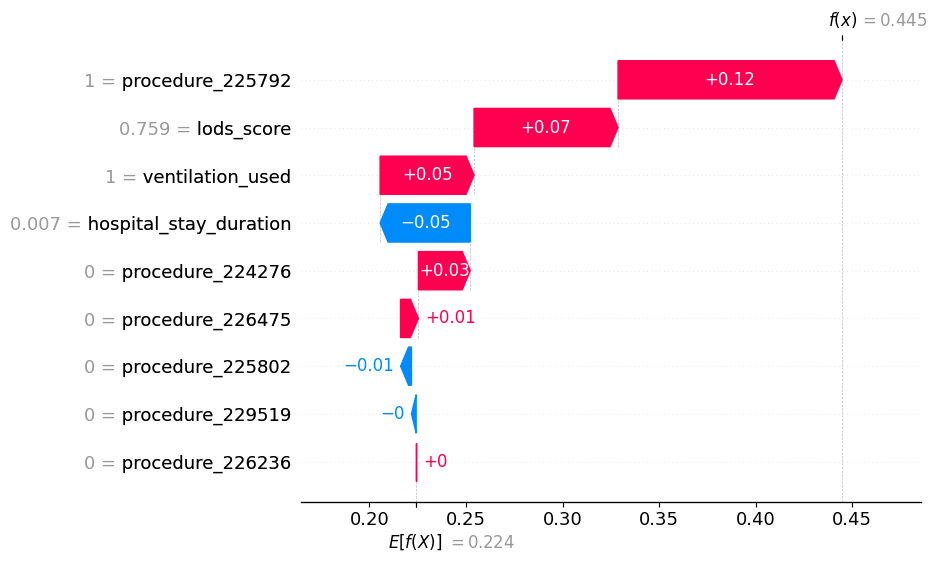

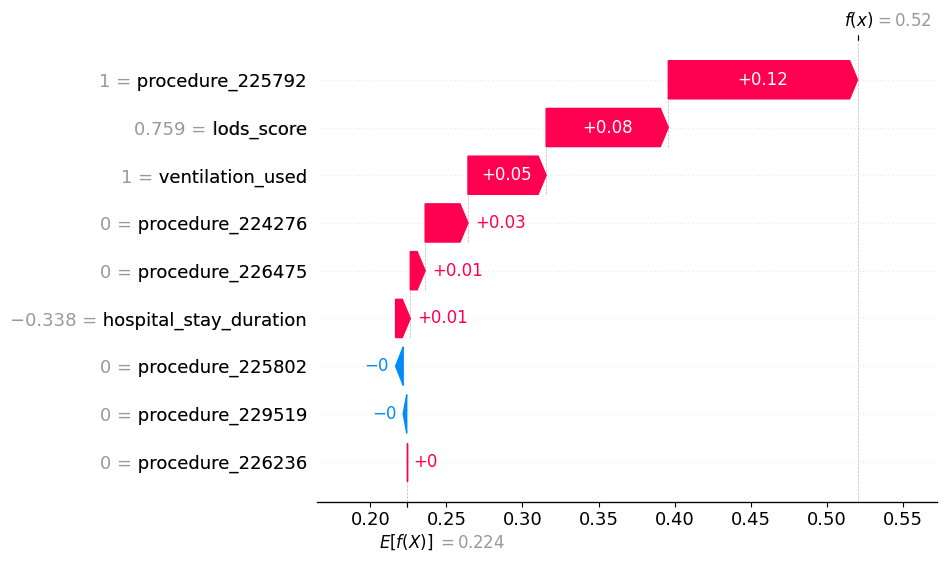

In [171]:
# Get predicted probabilities for the test dataset (assume binary classification, class 1 probability)
predicted_probabilities = model_predict(test_data[list(features_ordering[curve_input_features['Transformer']])])[:, 1]

count = 0
# Loop through the predictions and display SHAP waterfall plots for those with probability > 0.5
for i in range(len(predicted_probabilities)):

    if predicted_probabilities[i] < 0.5:  # Check if probability is greater than 0.5

        # Create a waterfall plot for the selected prediction
        shap.waterfall_plot(shap_values[i][:, 1])

        plt.show()

        count += 1

    if count > 10:
      break


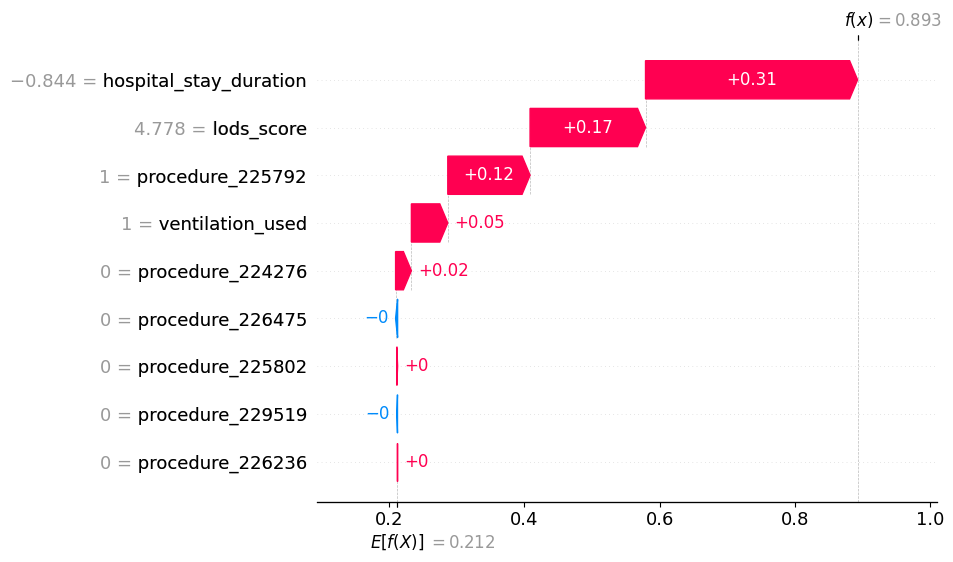

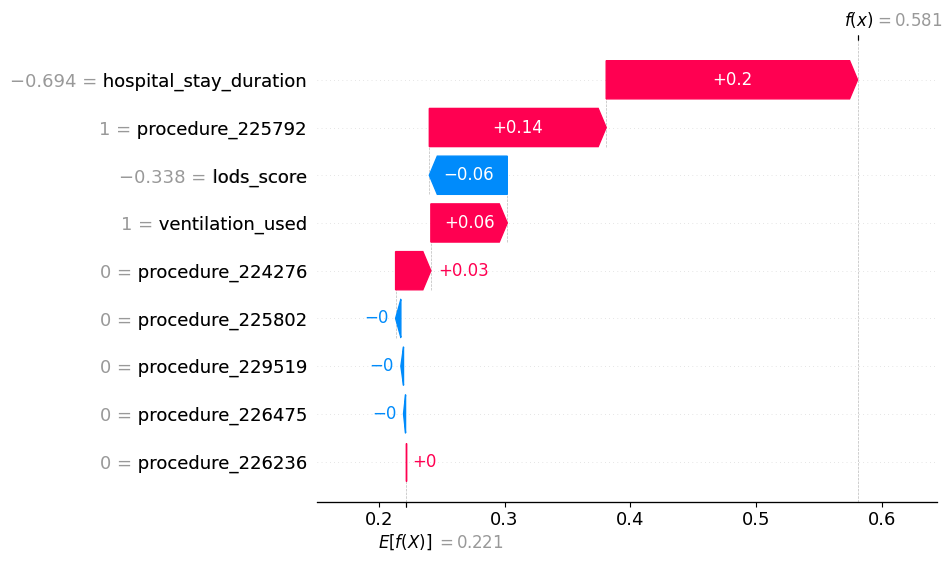

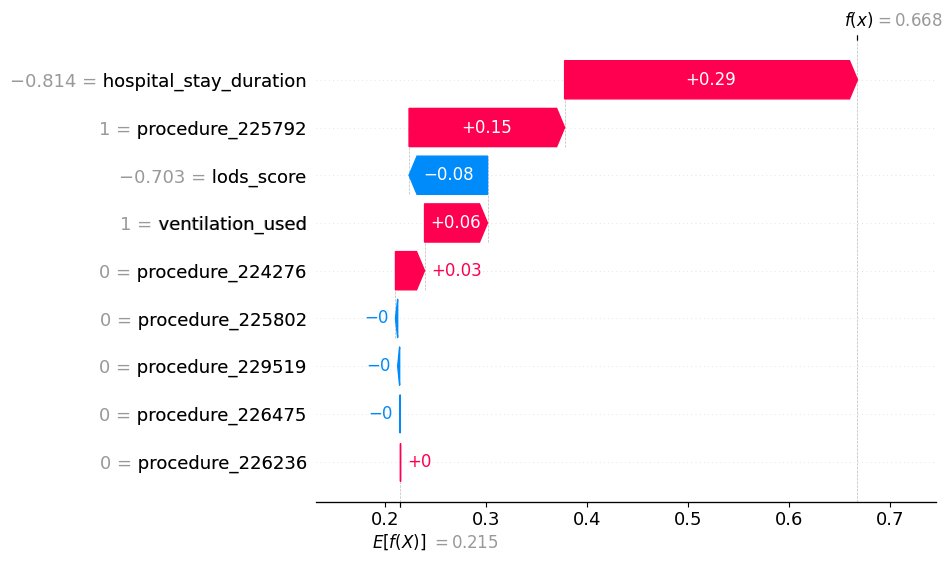

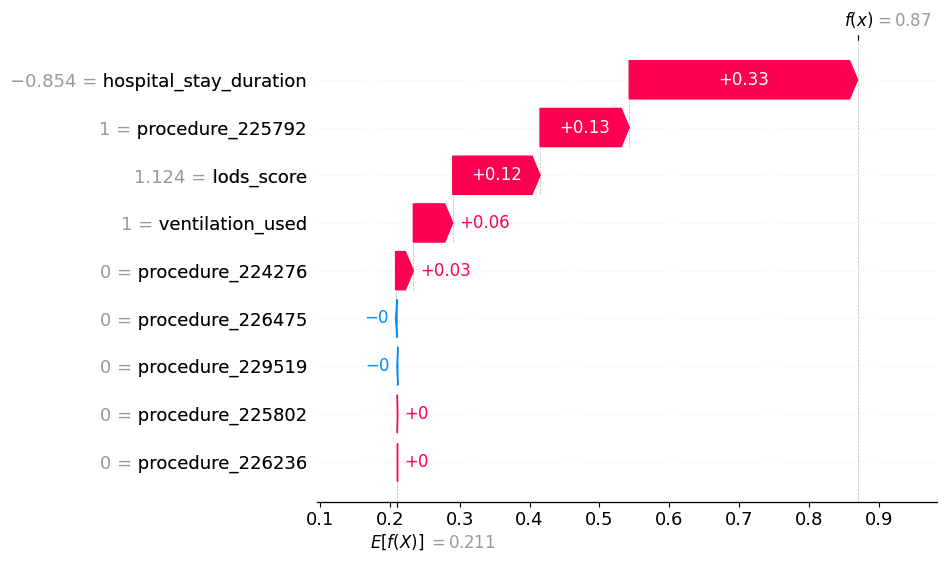

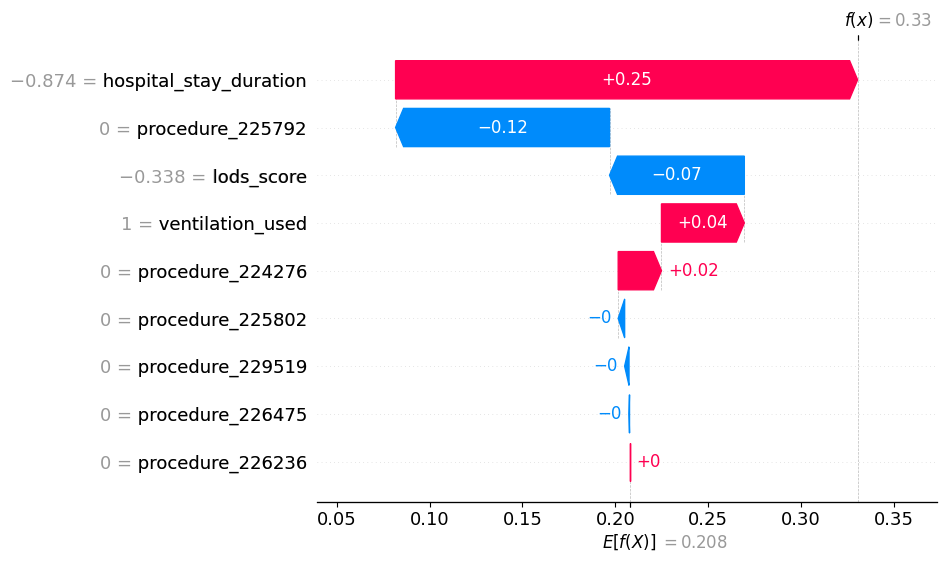

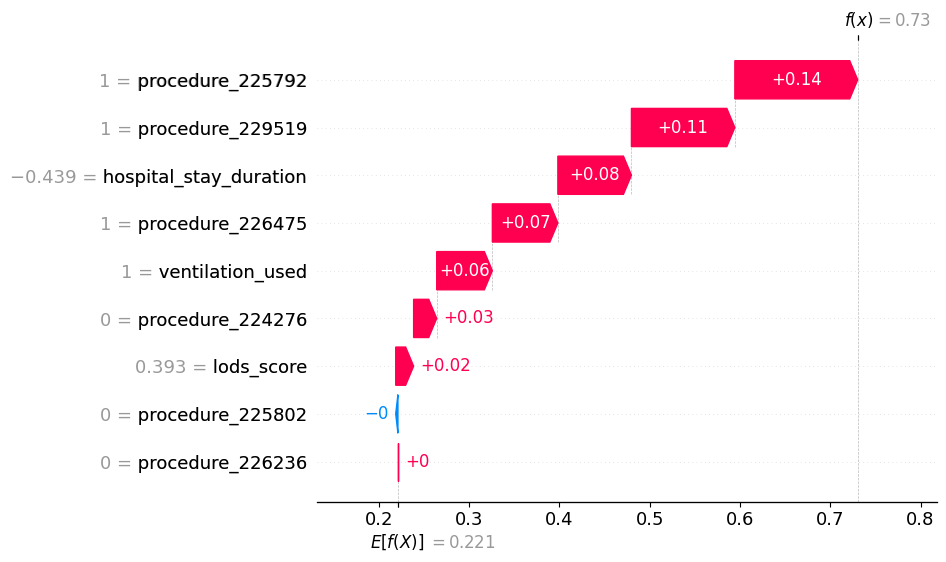

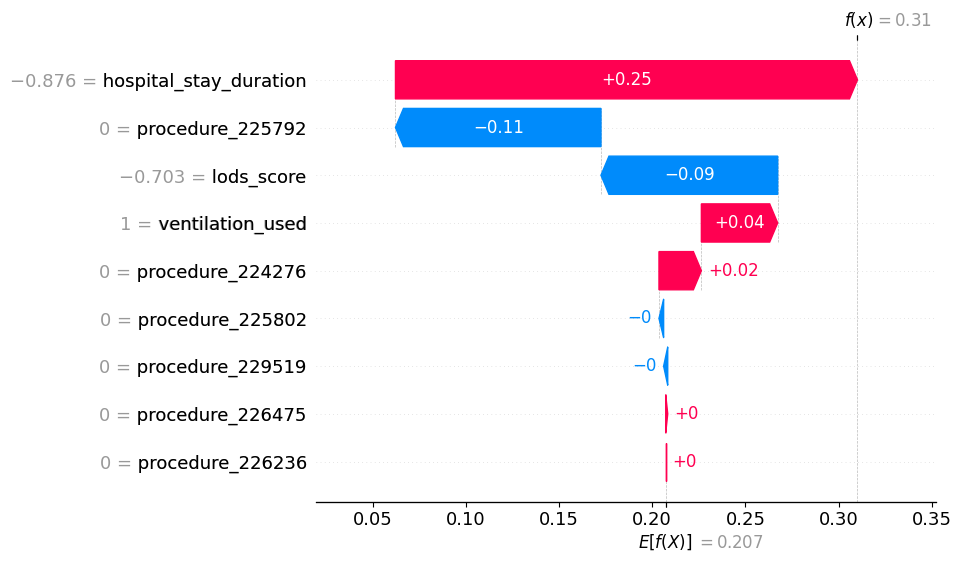

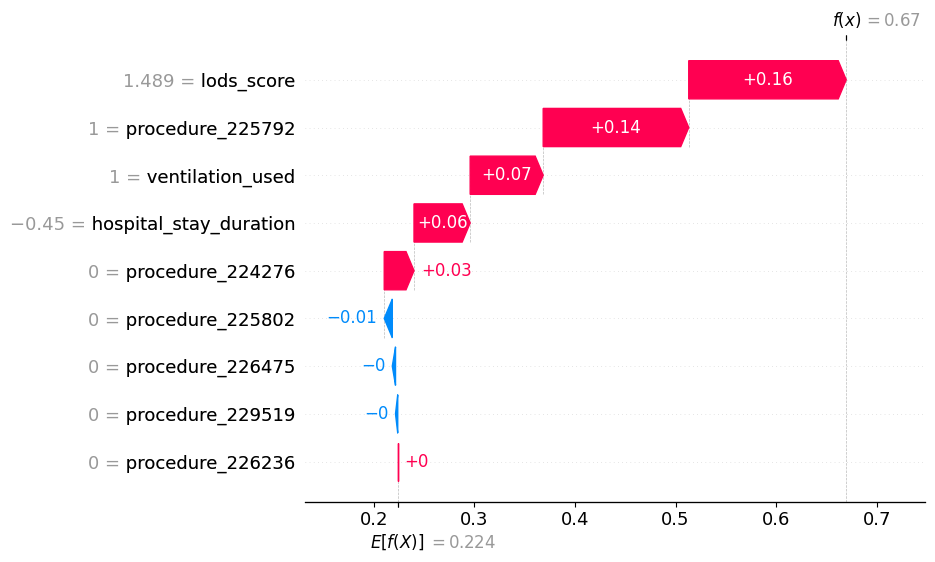

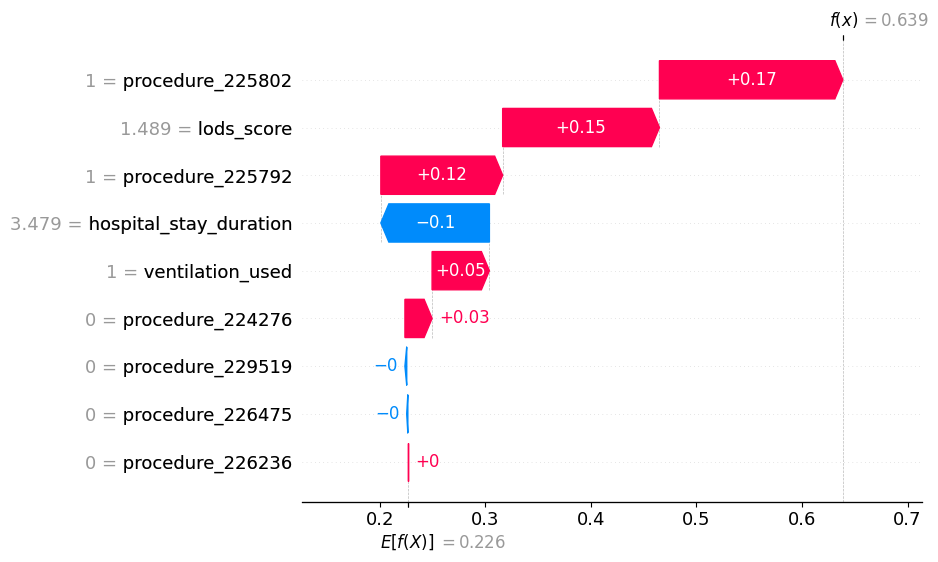

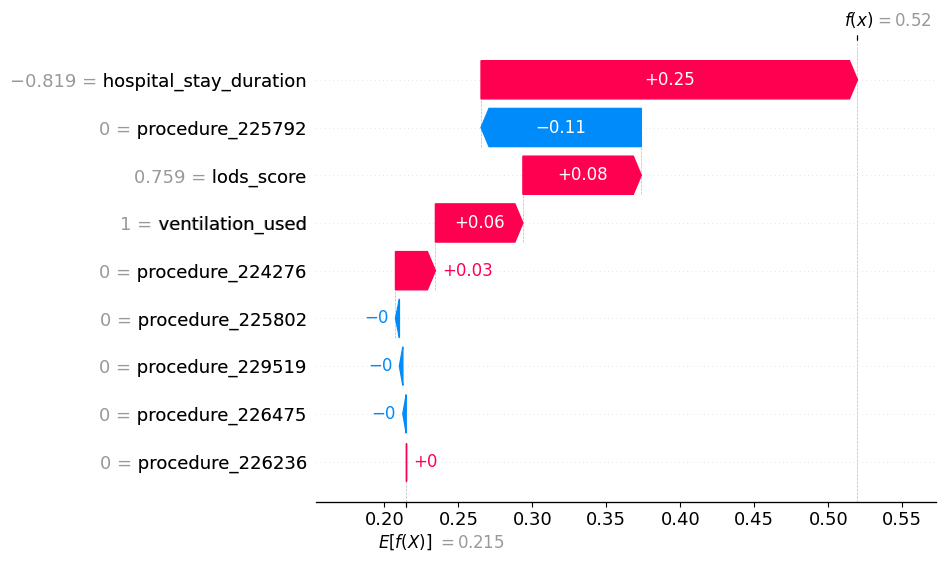

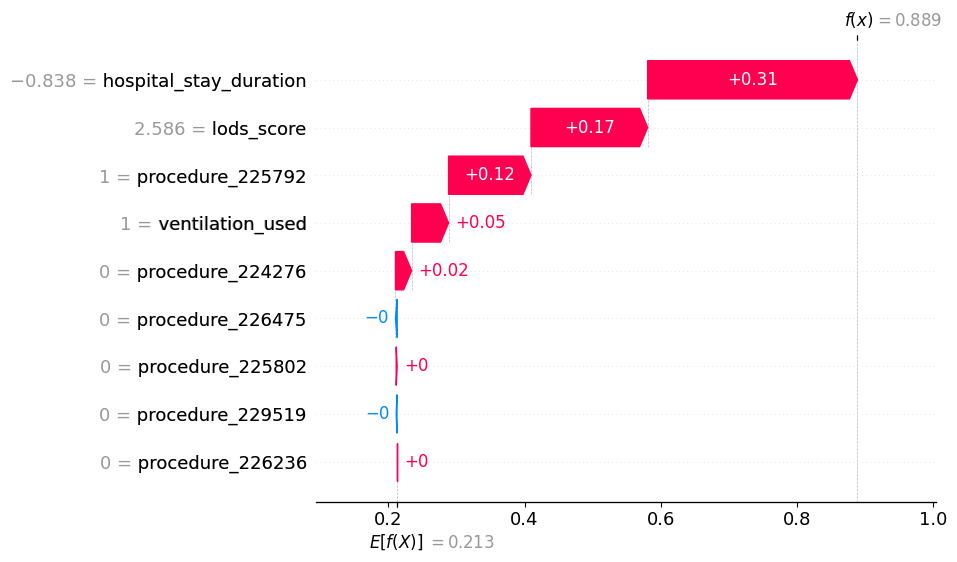

In [172]:
count = 0
# Loop through the predictions and display SHAP waterfall plots for those with probability > 0.5
for i in range(len(predicted_probabilities)):

    if predicted_probabilities[i] >= 0.5:  # Check if probability is greater than 0.5

        # Create a waterfall plot for the selected prediction
        shap.waterfall_plot(shap_values[i][:, 1])

        plt.show()

        count += 1

    if count > 10:
      break


In [ ]:
s